<a href="https://colab.research.google.com/github/im-karthikrajesh/hotel-booking-cancellations-geo-ml/blob/notebook2/Comprehensive_Data_Preparation_and_Feature_Engineering_Workflow_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Factors Driving Hotel Booking Cancellations: A Predictive and Geospatial Analysis**

### **Notebook 2: Comprehensive Data Preparation and Feature Engineering Workflow**

**Environment Setup**

In [ ]:
# Install Required Packages
%pip install --quiet pycountry rapidfuzz tabulate

# Standard Library
import os
import math
import random
import builtins
from pathlib import Path

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from IPython.display import display
import pycountry
from rapidfuzz import process, fuzz
from scipy import stats
import scipy.stats as ss

# Scikit-Learn (Machine Learning)
import sklearn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Pandas Display Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.4 MB/s eta 0:00:00


**Data Ingestion**

In [ ]:
# Dataset configuration
DATA_FILES = {
    'bookings': {
        'path': Path('hotel_bookings.csv'),
        'parse_dates': ['reservation_status_date']
    },
    'wdi': {
        'path': Path('wdi_long.csv'),
        'parse_dates': None
    },
    'hofstede': {
        'path': Path('hofstede.csv'),
        'parse_dates': None
    }
}

def load_dataset(name: str, config: dict) -> pd.DataFrame:
    """
    Loads CSV file into the pandas DataFrame.
    Args:
        name: Logical dataset name.
        config: Dict with keys:
            - 'path': Path to the CSV file.
            - 'parse_dates': List of columns to parse as dates.
    Returns:
        The loaded DataFrame.
    """
    path: Path = config['path']
    if not path.exists():
        raise FileNotFoundError(f"File for '{name}' not found at {path.resolve()}")

    df = pd.read_csv(path, parse_dates=config.get('parse_dates') or [])
    print(f"Loaded {name} - shape: {df.shape}")

    # Report dtypes for any parsed date columns
    if config.get('parse_dates'):
        for col in config['parse_dates']:
            print(f"{col} dtype: {df[col].dtype}")

    return df

# Load all datasets
datasets: dict[str, pd.DataFrame] = {}
for name, cfg in DATA_FILES.items():
    datasets[name] = load_dataset(name, cfg)
    print()

def preview(name: str, df: pd.DataFrame, n: int = 5) -> None:
    """
    Display a quick preview of a DataFrame.
    Args:
        name: Logical dataset name.
        df: The DataFrame to preview.
        n: Number of rows to display.
    """
    print(f"--- {name} ---")
    display(df.head(n))
    print()

for name, df in datasets.items():
    preview(name, df)

Loaded bookings - shape: (119390, 32)
reservation_status_date dtype: datetime64[ns]

Loaded wdi - shape: (10374, 6)

Loaded hofstede - shape: (111, 8)

--- bookings ---


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03



--- wdi ---


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Africa Eastern and Southern,AFE,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,2015,3.004937
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,2015,1479.564123
2,Africa Eastern and Southern,AFE,Individuals using the Internet (% of population),IT.NET.USER.ZS,2015,NaN
3,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,2015,5.245878
4,Africa Eastern and Southern,AFE,"International tourism, number of departures",ST.INT.DPRT,2015,NaN



--- hofstede ---


,country_code,country_name,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.000000,40.000000
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.000000,78.000000
2,ALB,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929
3,ALG,Algeria,NaN,NaN,NaN,NaN,25.944584,32.366071
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000


**ISO3 Country Code Validation & Cleaning**

In [ ]:
# Build set of valid ISO-3 codes
valid_iso3 = {c.alpha_3 for c in pycountry.countries}

# Map dataset to its country‐code column
country_fields = {
    'bookings': 'country',
    'wdi': 'Country Code',
    'hofstede': 'country_code',
}

# Uppercase everything
for name, field in country_fields.items():
    datasets[name][field] = datasets[name][field].str.upper()

# Initial invalid‐code report
print("\n>> Initial ISO-3 Validation")
for name, field in country_fields.items():
    codes = set(datasets[name][field].dropna().unique())
    invalid = sorted(codes - valid_iso3)
    print(f"{name:9}: {len(codes)} codes, {len(invalid)} invalid")
    if invalid:
        print(f"Invalid: {invalid}\n")

# Bookings - ISO-2 → ISO-3 Mapping
alpha2_to_3 = {c.alpha_2: c.alpha_3 for c in pycountry.countries}
book = datasets['bookings'].copy()
iso2_present = sorted(c for c in book['country'].unique() if c in alpha2_to_3)

book['country'] = book['country'].map(lambda c: alpha2_to_3.get(c, c))
book['country'] = book['country'].replace({'TMP': 'TLS'})  # Timor-Leste
datasets['bookings'] = book

print(">> Bookings ISO-2→ISO-3 Mapping")
for iso2 in iso2_present:
    iso3 = alpha2_to_3[iso2]
    print(f"{iso2} → {iso3}: {(book['country']==iso3).sum()} rows")
print(f"TMP → TLS: {(book['country']=='TLS').sum()} rows\n")

# Hofstede — Fuzzy + Manual Mapping & Deduplication
raw_hof = datasets['hofstede'].copy()
raw_hof['country_code'] = raw_hof['country_code'].str.upper()
raw_hof['country_name'] = raw_hof['country_name'].str.strip()
raw_hof['orig_code'] = raw_hof['country_code']  # preserve original

# Identify invalid codes
invalid_hof = (
    raw_hof.loc[~raw_hof['orig_code'].isin(valid_iso3),
                ['country_name','orig_code']]
    .drop_duplicates().reset_index(drop=True)
)

# Fuzzy-match suggestions
official = [c.name for c in pycountry.countries]
suggestions = []
for _, row in invalid_hof.iterrows():
    nm, orig = row['country_name'], row['orig_code']
    match, score, _ = process.extractOne(nm, official, scorer=fuzz.token_sort_ratio)
    iso3 = pycountry.countries.get(name=match).alpha_3 if score >= 80 else None
    suggestions.append({
        'orig_code': orig,
        'country_name': nm,
        'match_name': match,
        'score': score,
        'suggested_iso3': iso3
    })
suggest_df = pd.DataFrame(suggestions)

print("Hofstede: Fuzzy-Mapped (score >= 80)")
print(suggest_df[suggest_df.suggested_iso3.notnull()]
      [['orig_code','country_name','match_name','suggested_iso3']]
      .to_string(index=False))
print("\n Hofstede: Still Unmapped")
print(suggest_df[suggest_df.suggested_iso3.isnull()]
      [['orig_code','country_name','score']]
      .to_string(index=False))

# Apply fuzzy map
fuzzy_map = dict(zip(
    suggest_df.orig_code[suggest_df.suggested_iso3.notnull()],
    suggest_df.suggested_iso3[suggest_df.suggested_iso3.notnull()]
))
hof = raw_hof.copy()
hof['country_code'] = hof['orig_code'].map(lambda c: fuzzy_map.get(c, c))

# Manual fixes (true national codes)
manual_map = {
    'BEF':'BEL',  # Belgium French → BEL
    'BOS':'BIH',  # Bosnia
    'GEE':'DEU',  # Germany East → DEU
    'IRA':'IRN',  # Iran
    'KYR':'KGZ',  # Kyrgyz Rep
    'MOL':'MDA',  # Moldova
    'SWF':'CHE',  # Switzerland French → CHE
    'SWG':'CHE',  # Switzerland German → CHE
    'SAL':'SLV',  # El Salvador → SLV
    'SLV':'SVN',  # Slovenia → SVN
    'TAI':'TWN',  # Taiwan
    'TAN':'TZA',  # Tanzania
    'VIE':'VNM',  # Vietnam
}
print("\n>> Manual Mapping:")
for orig, iso3 in manual_map.items():
    cnt = (hof['orig_code']==orig).sum()
    hof.loc[hof['orig_code']==orig, 'country_code'] = iso3
    print(f"{orig} → {iso3}: {cnt} rows")

# Drop sub-national/language slices (except South Africa)
drop_subnational = {'BEF','SWF','SWG','GEE'}  # remove Belgium French, Swiss French/German, East Germany
hof = hof[~hof['orig_code'].isin(drop_subnational)].copy()

# Drop any remaining invalid codes (aggregates)
hof = hof[hof['country_code'].isin(valid_iso3)].reset_index(drop=True)

# Show ZAF duplicates before merge
dupe_codes = sorted(set(
    hof.loc[hof.duplicated('country_code', keep=False), 'country_code']
))
print(f"\n>> ISO-3 duplicates to merge: {dupe_codes}")

print("\n>> Details of ZAF duplicate rows:")
print(
    hof[hof['country_code']=='ZAF']
      .to_string(index=False)
)

# Merge duplicates: average numeric, first of others
numeric_cols = hof.select_dtypes(include='number').columns.tolist()
non_numeric_cols = [c for c in hof.columns if c not in numeric_cols + ['orig_code']]
agg_dict = {c:'first' for c in non_numeric_cols}
agg_dict.update({c:'mean' for c in numeric_cols})

hof_merged = hof.groupby('country_code', as_index=False).agg(agg_dict)
print(f">> Merged duplicates; final count: {len(hof_merged)} countries")

# Final Hofstede ISO-3 list
final_codes = sorted(hof_merged['country_code'])
print("\n--- Final Hofstede ISO-3 Codes ---")
print(final_codes)

datasets['hofstede'] = hof_merged

# WDI — Report then filter to valid ISO-3 only
wdi = datasets['wdi'].copy()

# Identify invalid codes in WDI
all_wdi_codes = set(wdi['Country Code'].dropna().unique())
invalid_wdi_codes = sorted(all_wdi_codes - valid_iso3)

print(f">> WDI initial codes: {len(all_wdi_codes)} unique")
print(f">> Invalid WDI codes to remove ({len(invalid_wdi_codes)}):")
print(invalid_wdi_codes)

# Filter out the invalid codes
before_wdi = len(wdi)
wdi_clean = wdi[wdi['Country Code'].isin(valid_iso3)].reset_index(drop=True)
after_wdi = len(wdi_clean)

print(f"\n>> WDI cleaned: kept {after_wdi}/{before_wdi}, dropped {before_wdi-after_wdi}\n")
datasets['wdi'] = wdi_clean

# Final Validation
print(">> Final ISO-3 Validation")
for name, field in country_fields.items():
    codes = set(datasets[name][field].dropna().unique())
    invalid = sorted(codes - valid_iso3)
    if invalid:
        raise ValueError(f"{name}: still invalid → {invalid[:5]}")
    print(f"{name:9}: {len(codes)} codes valid")
print("\nAll datasets now use valid ISO-3 country codes.")



>> Initial ISO-3 Validation
bookings : 177 codes, 2 invalid
Invalid: ['CN', 'TMP']

wdi      : 266 codes, 51 invalid
Invalid: ['AFE', 'AFW', 'ARB', 'CEB', 'CHI', 'CSS', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'INX', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MIC', 'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PSS', 'PST', 'SAS', 'SSA', 'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'TSS', 'UMC', 'WLD', 'XKX']

hofstede : 111 codes, 53 invalid
Invalid: ['AFE', 'AFW', 'ALG', 'ARA', 'AUL', 'BAN', 'BEF', 'BOS', 'BUF', 'BUL', 'CHI', 'COS', 'CRO', 'DEN', 'ECA', 'GEE', 'GER', 'GRE', 'GUA', 'HOK', 'ICE', 'IDO', 'IRA', 'IRE', 'KYR', 'LAT', 'LIT', 'MAL', 'MOL', 'MOR', 'NET', 'NIG', 'PHI', 'POR', 'PUE', 'ROM', 'SAF', 'SAL', 'SAW', 'SER', 'SIN', 'SLK', 'SPA', 'SWF', 'SWG', 'SWI', 'TAI', 'TAN', 'TRI', 'URU', 'VIE', 'ZAM', 'ZIM']

>> Bookings ISO-2→ISO-3 Mapping
CN → CHN: 2278 rows
TMP → TLS: 3 rows

Hofstede: Fuzzy-Mapped (scor

**Business & Data Understanding**


--- BOOKINGS OVERVIEW ---
Shape: (119390, 32)



,dtype,missing,unique
hotel,object,0,2
is_canceled,int64,0,2
lead_time,int64,0,479
arrival_date_year,int64,0,3
arrival_date_month,object,0,12
arrival_date_week_number,int64,0,53
arrival_date_day_of_month,int64,0,31
stays_in_weekend_nights,int64,0,17
stays_in_week_nights,int64,0,35
adults,int64,0,14


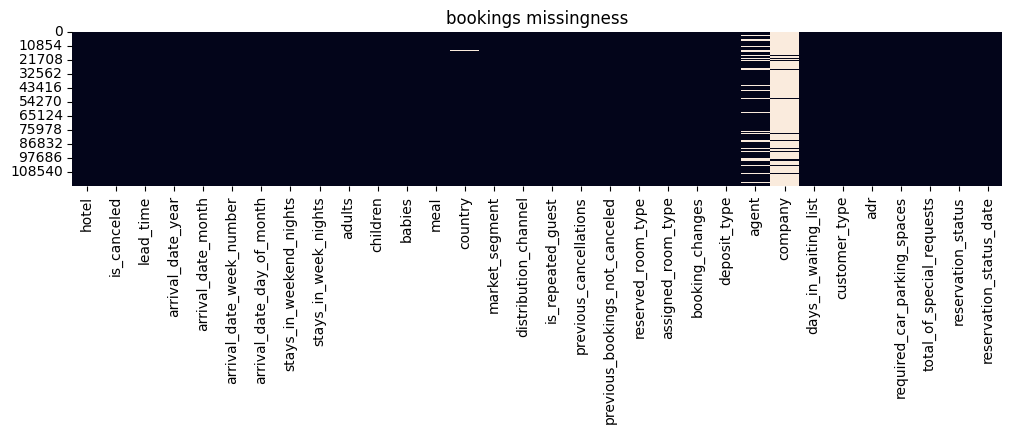

Datetime column ranges:
 * reservation_status_date: dtype=datetime64[ns], min=2014-10-17 00:00:00, max=2017-09-14 00:00:00

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370,0.483,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011,106.863,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.157,0.707,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165,13.605,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798,8.781,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.928,0.999,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500,1.908,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856,0.579,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.104,0.399,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.008,0.097,0.00,0.00,0.000,0.0,10.0



Top-5 values for each categorical column:
 * hotel:
'City Hotel': 79330
'Resort Hotel': 40060
 * arrival_date_month:
'August': 13877
'July': 12661
'May': 11791
'October': 11160
'April': 11089
 * meal:
'BB': 92310
'HB': 14463
'SC': 10650
'Undefined': 1169
'FB': 798
 * country:
'PRT': 48590
'GBR': 12129
'FRA': 10415
'ESP': 8568
'DEU': 7287
 * market_segment:
'Online TA': 56477
'Offline TA/TO': 24219
'Groups': 19811
'Direct': 12606
'Corporate': 5295
 * distribution_channel:
'TA/TO': 97870
'Direct': 14645
'Corporate': 6677
'GDS': 193
'Undefined': 5
 * reserved_room_type:
'A': 85994
'D': 19201
'E': 6535
'F': 2897
'G': 2094
 * assigned_room_type:
'A': 74053
'D': 25322
'E': 7806
'F': 3751
'G': 2553
 * deposit_type:
'No Deposit': 104641
'Non Refund': 14587
'Refundable': 162
 * customer_type:
'Transient': 89613
'Transient-Party': 25124
'Contract': 4076
'Group': 577
 * reservation_status:
'Check-Out': 75166
'Canceled': 43017
'No-Show': 1207

BOOKINGS sample rows:


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03



--------------------------------------------------------------------------------


--- WDI OVERVIEW ---
Shape: (8385, 6)



,dtype,missing,unique
Country Name,object,0,215
Country Code,object,0,215
Indicator Name,object,0,13
Indicator Code,object,0,13
Year,int64,0,3
Value,float64,768,7379


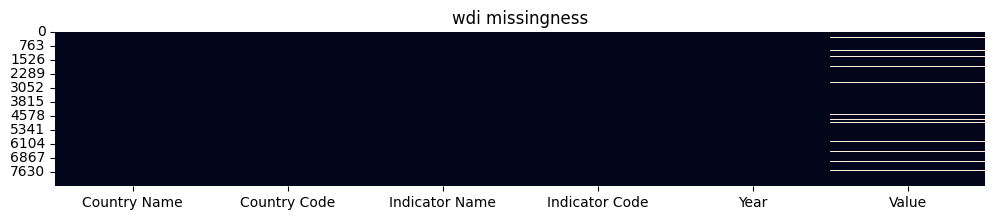


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Year,8385.0,2.016000e+03,8.170000e-01,2015.000,2015.000,2016.000,2017.000,2.017000e+03
Value,7617.0,4.815347e+08,5.543455e+09,-27.995,8.131,65.771,3152.309,2.337580e+11



Top-5 values for each categorical column:
 * Country Name:
'Afghanistan': 39
'Albania': 39
'Algeria': 39
'American Samoa': 39
'Andorra': 39
 * Country Code:
'AFG': 39
'ALB': 39
'DZA': 39
'ASM': 39
'AND': 39
 * Indicator Name:
'GDP growth (annual %)': 645
'GDP per capita (current US$)': 645
'Individuals using the Internet (% of population)': 645
'Inflation, consumer prices (annual %)': 645
'International tourism, number of departures': 645
 * Indicator Code:
'NY.GDP.MKTP.KD.ZG': 645
'NY.GDP.PCAP.CD': 645
'IT.NET.USER.ZS': 645
'FP.CPI.TOTL.ZG': 645
'ST.INT.DPRT': 645

WDI sample rows:


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,2015,1.451315
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,2015,565.569730
2,Afghanistan,AFG,Individuals using the Internet (% of population),IT.NET.USER.ZS,2015,8.260000
3,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,2015,-0.661709
4,Afghanistan,AFG,"International tourism, number of departures",ST.INT.DPRT,2015,NaN



--------------------------------------------------------------------------------


--- HOFSTEDE OVERVIEW ---
Shape: (102, 8)



,dtype,missing,unique
country_code,object,0,102
country_name,object,0,102
pdi,float64,31,49
idv,float64,31,52
mas,float64,31,46
uai,float64,31,48
ltowvs,float64,11,85
ivr,float64,10,86


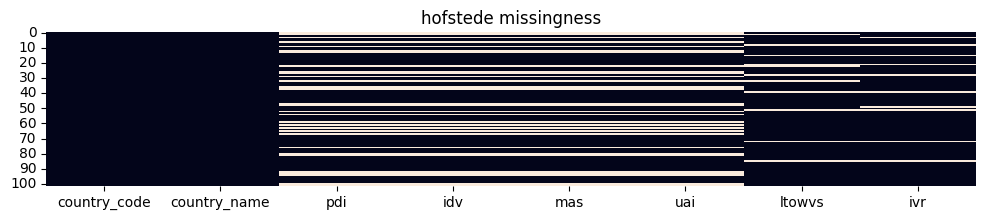


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
pdi,71.0,58.310,20.897,11.0,41.000,60.000,70.500,104.0
idv,71.0,44.803,24.358,6.0,21.500,41.000,67.500,91.0
mas,71.0,47.930,18.206,5.0,39.500,47.000,61.500,95.0
uai,71.0,68.056,23.665,8.0,50.500,70.000,86.000,112.0
ltowvs,91.0,45.578,23.979,0.0,25.819,45.340,62.720,100.0
ivr,92.0,45.563,22.376,0.0,28.962,43.862,63.489,100.0



Top-5 values for each categorical column:
 * country_code:
'ALB': 1
'AND': 1
'ARG': 1
'ARM': 1
'AUS': 1
 * country_name:
'Albania': 1
'Andorra': 1
'Argentina': 1
'Armenia': 1
'Australia': 1

HOFSTEDE sample rows:


,country_code,country_name,pdi,idv,mas,uai,ltowvs,ivr
0,ALB,Albania,NaN,NaN,NaN,NaN,61.460957,14.508929
1,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.000000
2,ARG,Argentina,49.0,46.0,56.0,86.0,20.403023,61.830357
3,ARM,Armenia,NaN,NaN,NaN,NaN,60.957179,NaN
4,AUS,Australia,38.0,90.0,61.0,51.0,21.158690,71.428571



--------------------------------------------------------------------------------

--- Bookings vs WDI (167 common, 9 only in A, 48 only in B) ---
+----------------+------------------+
| Country Code   | Category         |
|----------------+------------------|
| ABW            | Common           |
| AGO            | Common           |
| ALB            | Common           |
| AND            | Common           |
| ARE            | Common           |
| ARG            | Common           |
| ARM            | Common           |
| ASM            | Common           |
| AUS            | Common           |
| AUT            | Common           |
| AZE            | Common           |
| BDI            | Common           |
| BEL            | Common           |
| BEN            | Common           |
| BFA            | Common           |
| BGD            | Common           |
| BGR            | Common           |
| BHR            | Common           |
| BHS            | Common           |
| BIH            

In [ ]:
def inspect_df(name: str, df: pd.DataFrame) -> None:

    # Shape & dtype/missing/unique overview
    print(f"\n--- {name.upper()} OVERVIEW ---")
    print(f"Shape: {df.shape}\n")
    overview = pd.DataFrame({
        'dtype':   df.dtypes,
        'missing': df.isnull().sum(),
        'unique':  df.nunique(dropna=False)
    })
    display(overview)

    # Missing-value heatmap
    plt.figure(figsize=(12, 2))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title(f"{name} missingness")
    plt.show()

    # 3. Datetime column summary
    dt_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
    if len(dt_cols):
        print("Datetime column ranges:")
        for col in dt_cols:
            print(f" * {col}: dtype={df[col].dtype}, min={df[col].min()}, max={df[col].max()}")

    # Numeric descriptive statistics
    num_df = df.select_dtypes(include=[np.number])
    if not num_df.empty:
        print("\nNumeric summary:")
        display(num_df.describe().transpose().round(3))

    # Top-5 categorical values
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols):
        print("\nTop-5 values for each categorical column:")
        for col in cat_cols:
            top5 = df[col].value_counts(dropna=False).head(5)
            print(f" * {col}:")
            for val, cnt in top5.items():
                print(f"{val!r}: {cnt}")

    print(f"\n{name.upper()} sample rows:")
    display(df.head())
    print("\n" + ("-" * 80) + "\n")

# Apply the helper to each dataset
for name, df in datasets.items():
    inspect_df(name, df)

# Country-code alignment across tables
book_codes = set(datasets['bookings']['country'].dropna())
wdi_codes = set(datasets['wdi']['Country Code'].dropna())
hof_codes = set(datasets['hofstede']['country_code'].dropna())

comparisons = {
    'Bookings vs WDI': (book_codes, wdi_codes),
    'Bookings vs Hofstede': (book_codes, hof_codes),
}

for title, (a, b) in comparisons.items():
    common = sorted(a & b)
    only_a = sorted(a - b)
    only_b = sorted(b - a)

    rows = (
        [(code, 'Common') for code in common] +
        [(code, f'Only in {title.split(" vs ")[0]}') for code in only_a] +
        [(code, f'Only in {title.split(" vs ")[1]}') for code in only_b]
    )

    print(f"--- {title} ({len(common)} common, {len(only_a)} only in A, {len(only_b)} only in B) ---")
    print(tabulate(rows, headers=['Country Code', 'Category'], tablefmt='psql'))
    print()

# Fraction of bookings with matching external codes
for ext_name, ext_codes in [('Hofstede', hof_codes), ('WDI', wdi_codes)]:
    mask = datasets['bookings']['country'].isin(ext_codes)
    n_total = len(datasets['bookings'])
    n_with  = mask.sum()
    pct_with = n_with / n_total
    print(f"Bookings with {ext_name} data: "
          f"{n_with:,} / {n_total:,} = {pct_with:.1%}")

**Cleaning, EDA & Feature Engineering for Bookings**

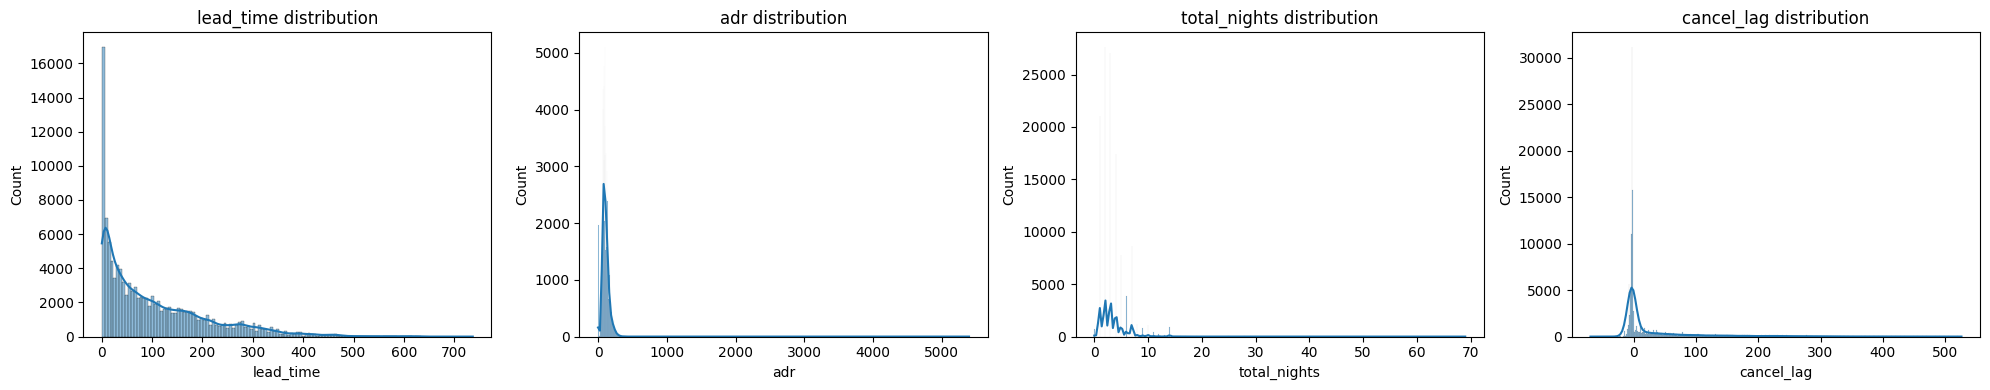

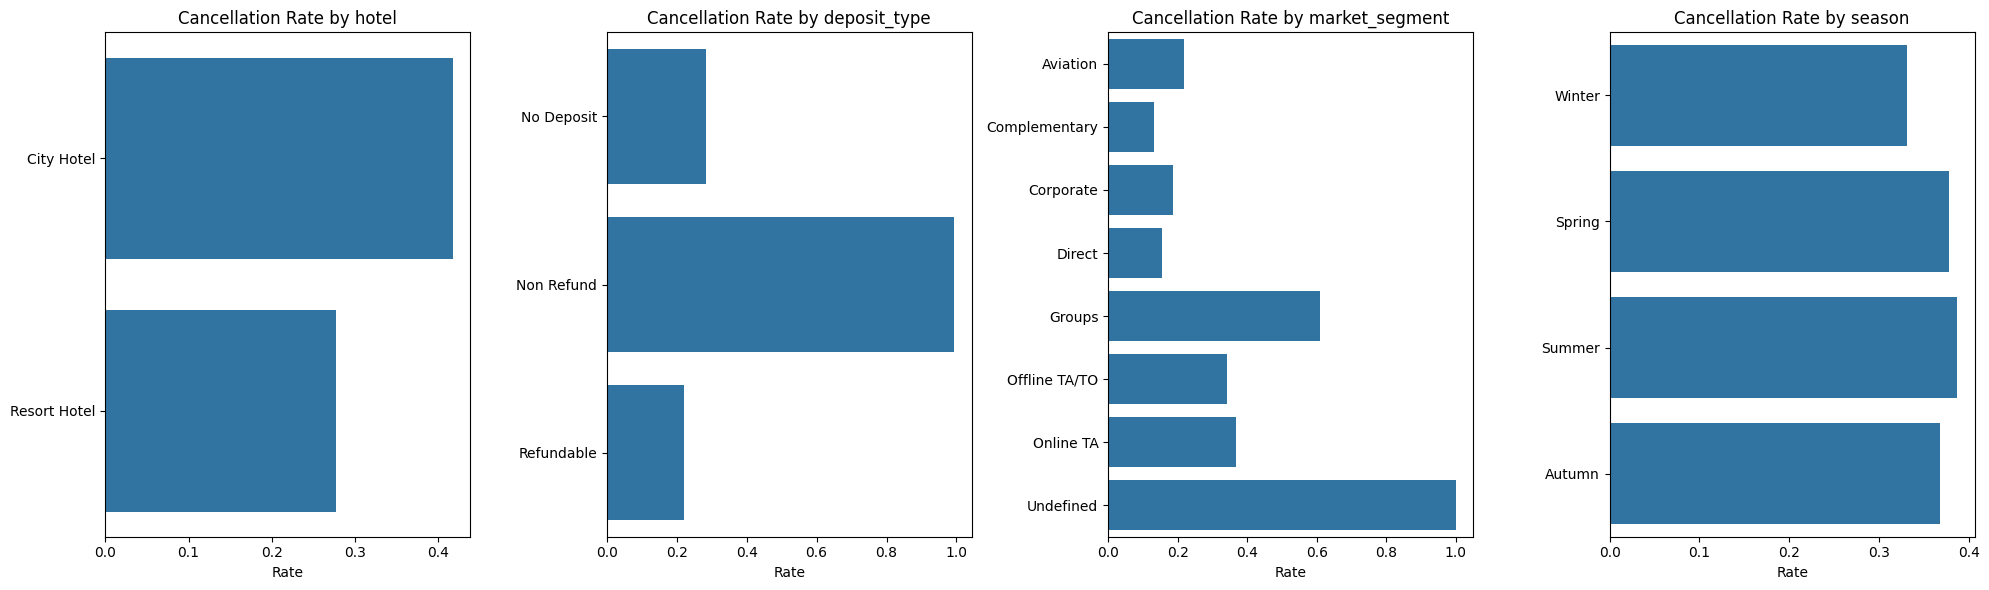

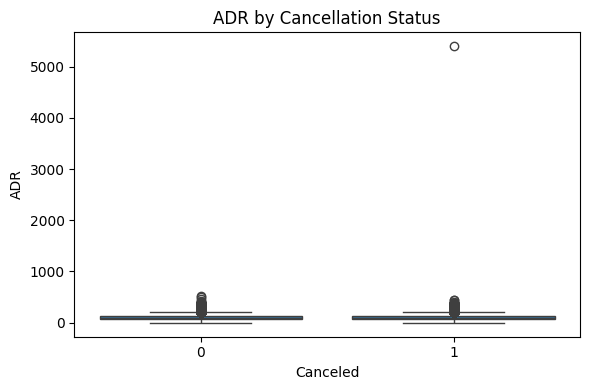

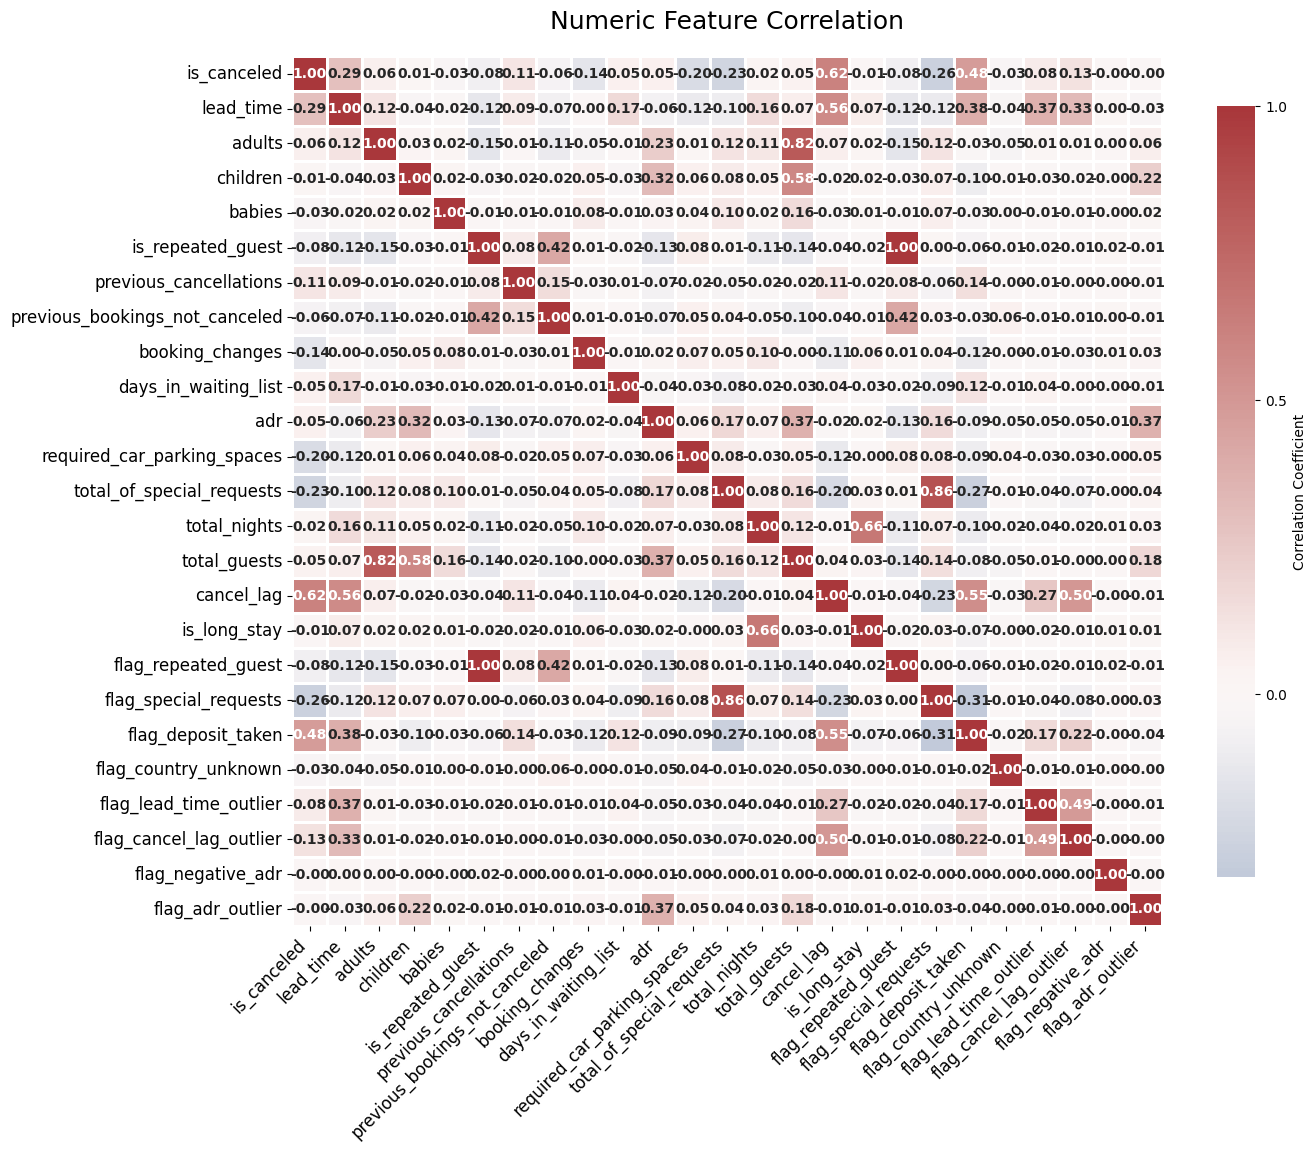

Final bookings shape: (119390, 41)


,dtype,missing,unique
hotel,category,0,2
is_canceled,int8,0,2
lead_time,int16,0,479
adults,int8,0,14
children,uint8,0,5
babies,int8,0,5
meal,category,0,5
country,category,0,177
market_segment,category,0,8
distribution_channel,category,0,5


Country-Year aggregates shape: (398, 4)


,country,arrival_year,bookings_count,cancellation_rate
0,ABW,2016,1,0.000000
1,ABW,2017,1,0.000000
2,AGO,2015,50,0.080000
3,AGO,2016,187,0.695187
4,AGO,2017,125,0.568000


In [ ]:
# Cleaning, EDA & Feature Engineering for Bookings

# Helper functions
def make_arrival_date(df: pd.DataFrame) -> pd.DataFrame:
    """Build a single datetime 'arrival_date' and drop original components"""
    df = df.copy()
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + ' ' +
        df['arrival_date_month'] + ' ' +
        df['arrival_date_day_of_month'].astype(str),
        format='%Y %B %d'
    )
    df.drop(columns=[
        'arrival_date_year', 'arrival_date_month',
        'arrival_date_week_number', 'arrival_date_day_of_month'
    ], inplace=True)
    return df

def downcast_df(df: pd.DataFrame, int_only: bool = True) -> pd.DataFrame:
    """Downcast int64 to smallest integer and float64 to float32 if requested"""
    df = df.copy()
    int_cols = df.select_dtypes(include='int64').columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    if not int_only:
        float_cols = df.select_dtypes(include='float64').columns
        df[float_cols] = df[float_cols].astype('float32')
    return df

# Cleaning & Feature Initialization
bk = datasets['bookings'].copy()

# Impute and cast children & country
bk['children'] = bk['children'].fillna(0).astype('uint8')
bk['country'] = bk['country'].fillna('UNK').astype('category')

# Impute agent as categorical
bk['agent'] = bk['agent'].fillna('NONE').astype('category')

# Drop company column entirely
bk.drop(columns=['company'], inplace=True)

# Construct arrival_date and arrival_year
bk = make_arrival_date(bk)
bk['arrival_year'] = bk['arrival_date'].dt.year.astype('category')

# Cast text fields to category
text_cats = [
    'hotel','meal','market_segment','distribution_channel',
    'reserved_room_type','assigned_room_type',
    'deposit_type','customer_type','reservation_status'
]
bk[text_cats] = bk[text_cats].astype('category')

# Pre‐feature-engineering: total nights, guests, cancel lag
bk['total_nights'] = bk['stays_in_weekend_nights'] + bk['stays_in_week_nights']
bk.drop(columns=['stays_in_weekend_nights','stays_in_week_nights'], inplace=True)

bk['total_guests'] = bk['adults'] + bk['children'] + bk['babies']
bk['cancel_lag'] = (bk['arrival_date'] - bk['reservation_status_date']).dt.days

# Binning & seasonal features
bk['lead_time_bin'] = pd.cut(
    bk['lead_time'],
    bins=[-1,7,30,90,180,bk['lead_time'].max()],
    labels=['0-7d','8-30d','31-90d','91-180d','>180d']
).astype('category')

season_map = {
    **dict.fromkeys([12,1,2],'Winter'),
    **dict.fromkeys([3,4,5],'Spring'),
    **dict.fromkeys([6,7,8],'Summer'),
    **dict.fromkeys([9,10,11],'Autumn')
}
bk['season'] = pd.Categorical(
    bk['arrival_date'].dt.month.map(season_map),
    categories=['Winter','Spring','Summer','Autumn'],
    ordered=True
)

# Boolean flags
bk['is_long_stay'] = (bk['total_nights'] > 7).astype('uint8')
bk['flag_repeated_guest'] = bk['is_repeated_guest'].astype('uint8')
bk['flag_special_requests']= (bk['total_of_special_requests'] > 0).astype('uint8')
bk['flag_deposit_taken'] = (bk['deposit_type'] != 'No Deposit').astype('uint8')
bk['flag_country_unknown'] = (bk['country'] == 'UNK').astype('uint8')

# Outlier flags (no clipping)
bk['flag_lead_time_outlier'] = (bk['lead_time'] > bk['lead_time'].quantile(0.99)).astype('uint8')
bk['flag_cancel_lag_outlier'] = (bk['cancel_lag'] > bk['cancel_lag'].quantile(0.99)).astype('uint8')
bk['flag_negative_adr'] = (bk['adr'] < 0).astype('uint8')
bk['flag_adr_outlier'] = (bk['adr'] > bk['adr'].quantile(0.99)).astype('uint8')

# EDA

# Numeric distributions
numeric_cols = ['lead_time','adr','total_nights','cancel_lag']
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(20,4))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(bk[col], kde=True, ax=ax)
    ax.set_title(f"{col} distribution")
plt.tight_layout()
plt.show()

# Cancellation rate by category
cat_cols = ['hotel','deposit_type','market_segment','season']
fig, axes = plt.subplots(1, len(cat_cols), figsize=(20,6))
for ax, cat in zip(axes, cat_cols):
    grp = bk.groupby(cat, observed=True)['is_canceled'].mean().sort_values()
    sns.barplot(x=grp.values, y=grp.index, ax=ax)
    ax.set_title(f"Cancellation Rate by {cat}")
    ax.set_xlabel("Rate")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

# ADR vs cancellation boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x='is_canceled', y='adr', data=bk)
plt.title("ADR by Cancellation Status")
plt.xlabel("Canceled")
plt.ylabel("ADR")
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = bk.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    square=True,
    linewidths=1,
    linecolor="white",
    cbar_kws={
        "shrink": 0.8,
        "label": "Correlation Coefficient",
        "ticks": [-1, -0.5, 0, 0.5, 1]
    },
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.title("Numeric Feature Correlation", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

# Final Downcast & Aggregation
bk = downcast_df(bk, int_only=False)

country_year = (
    bk.groupby(['country','arrival_year'], observed=True)
      .agg(
          bookings_count=('hotel','size'),
          cancellation_rate=('is_canceled','mean')
      )
      .reset_index()
)

# Sanity check
print("Final bookings shape:", bk.shape)
display(
    bk.dtypes.to_frame('dtype')
      .assign(missing=bk.isna().sum(),
              unique=bk.nunique())
)
print("Country-Year aggregates shape:", country_year.shape)
display(country_year.head())


**Cleaning, EDA & Feature Engineering for WDI**

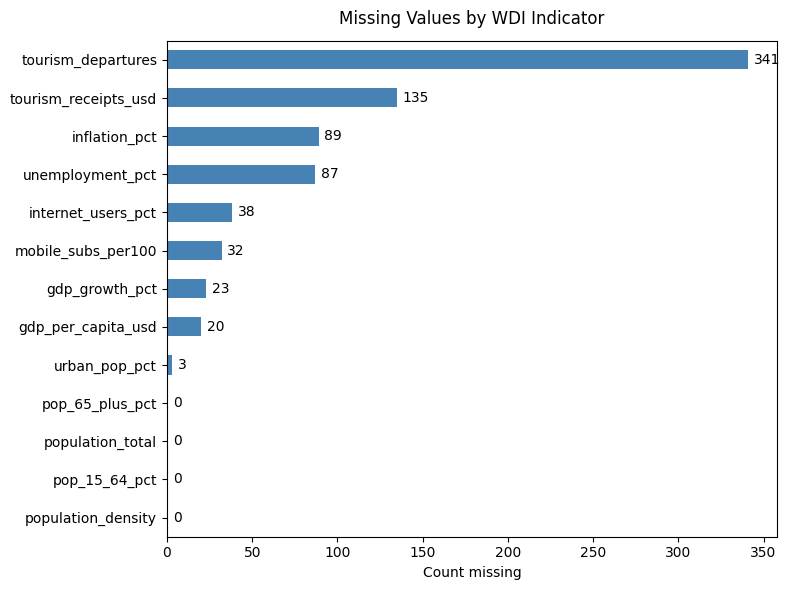

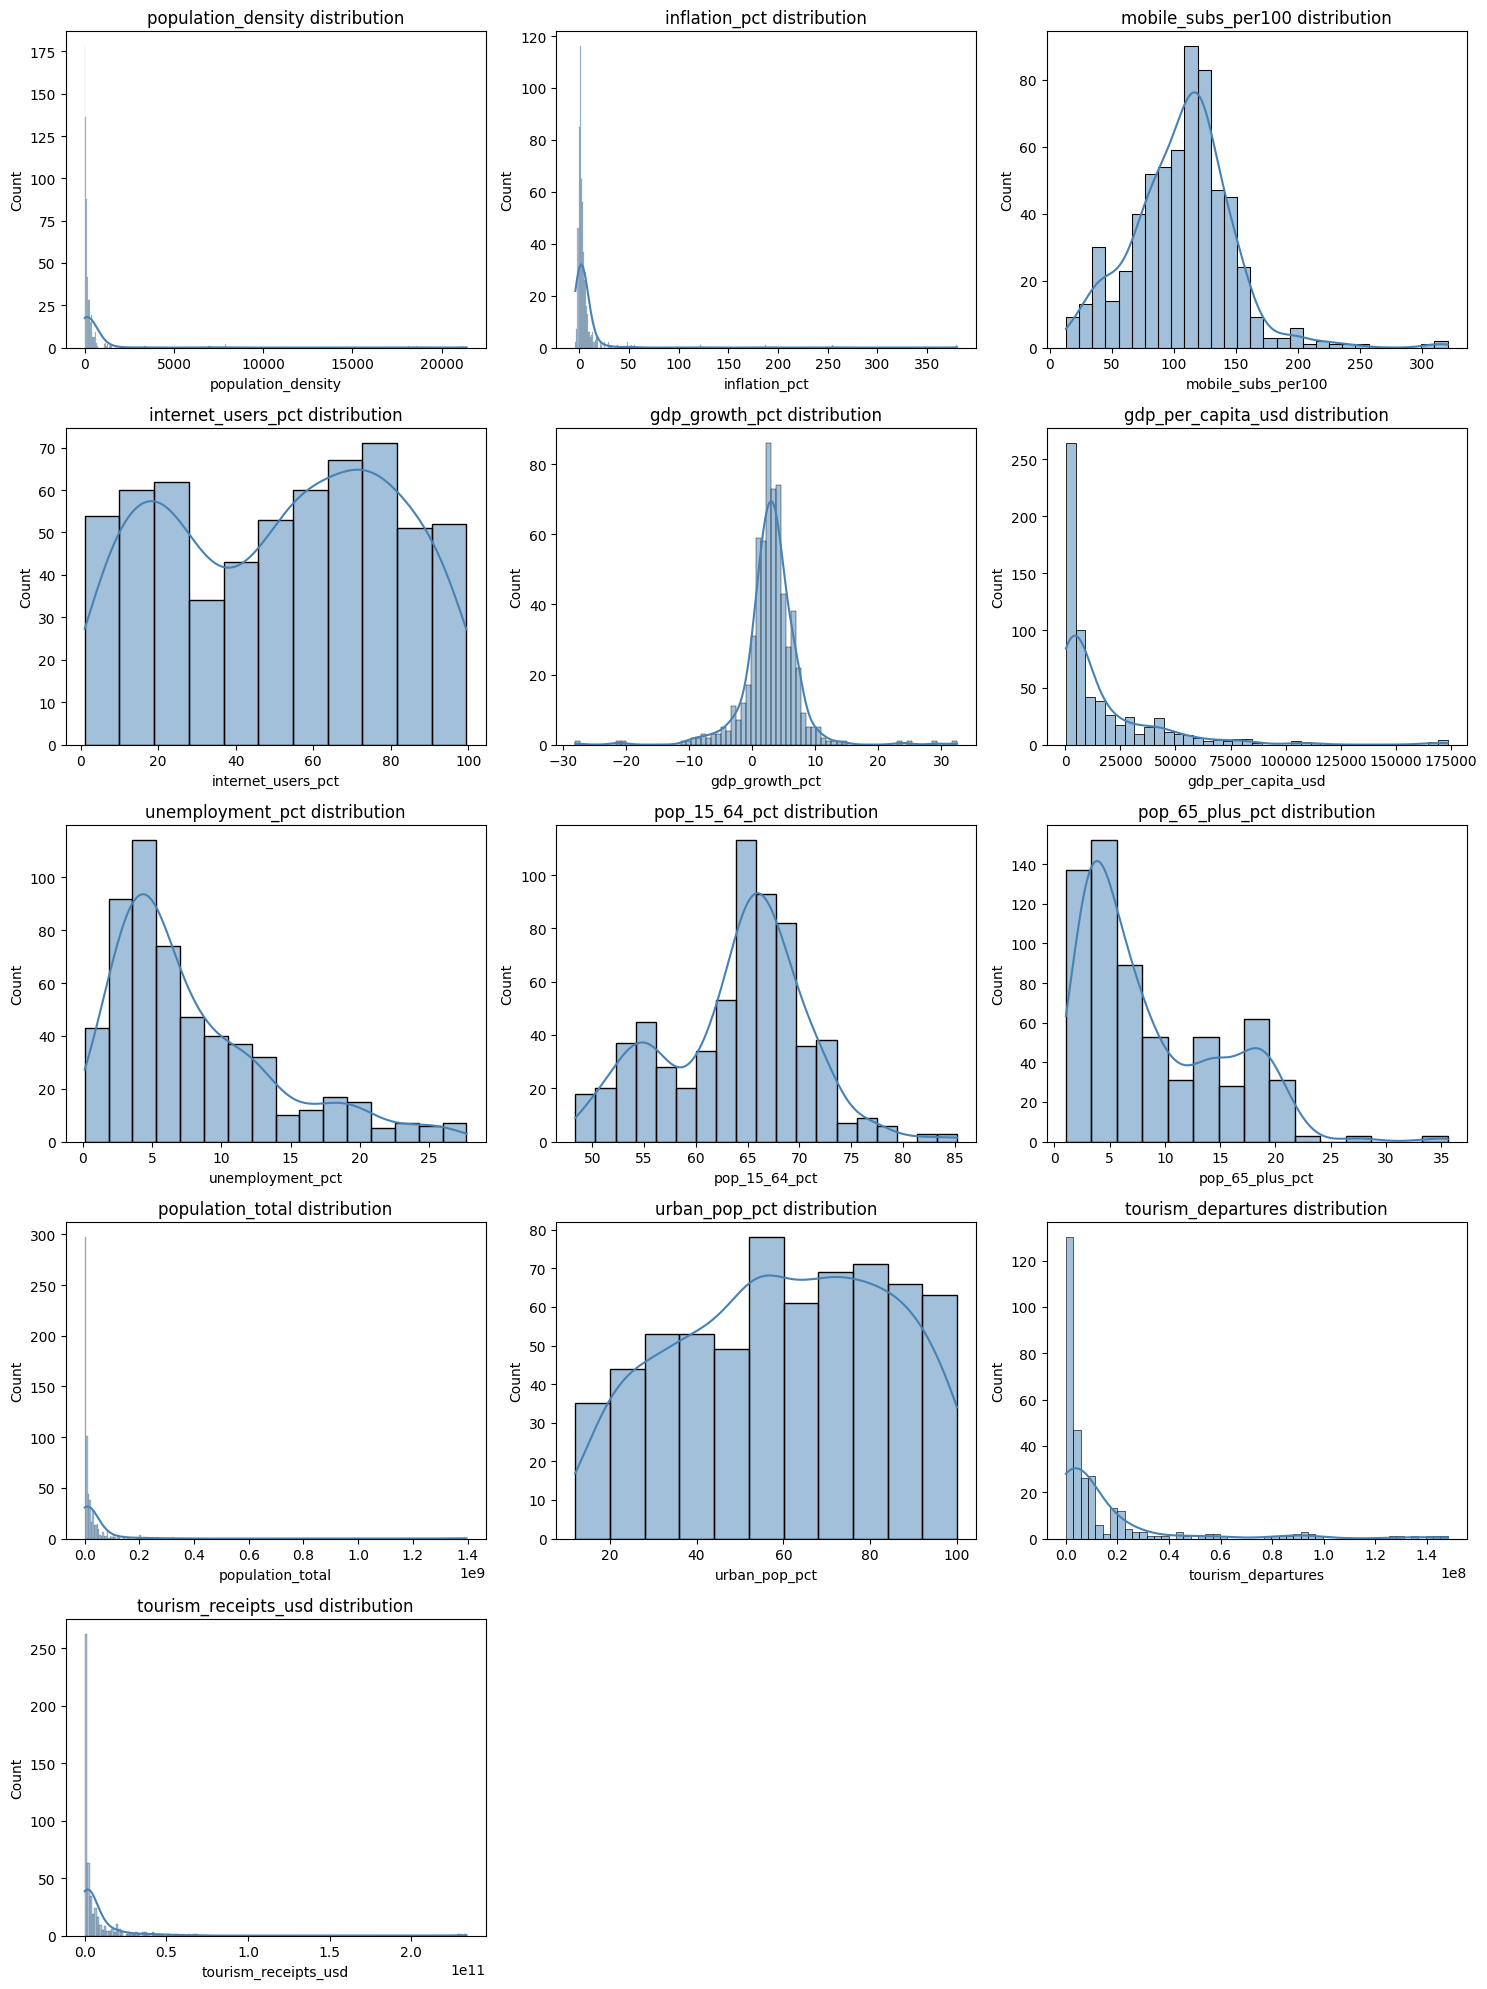

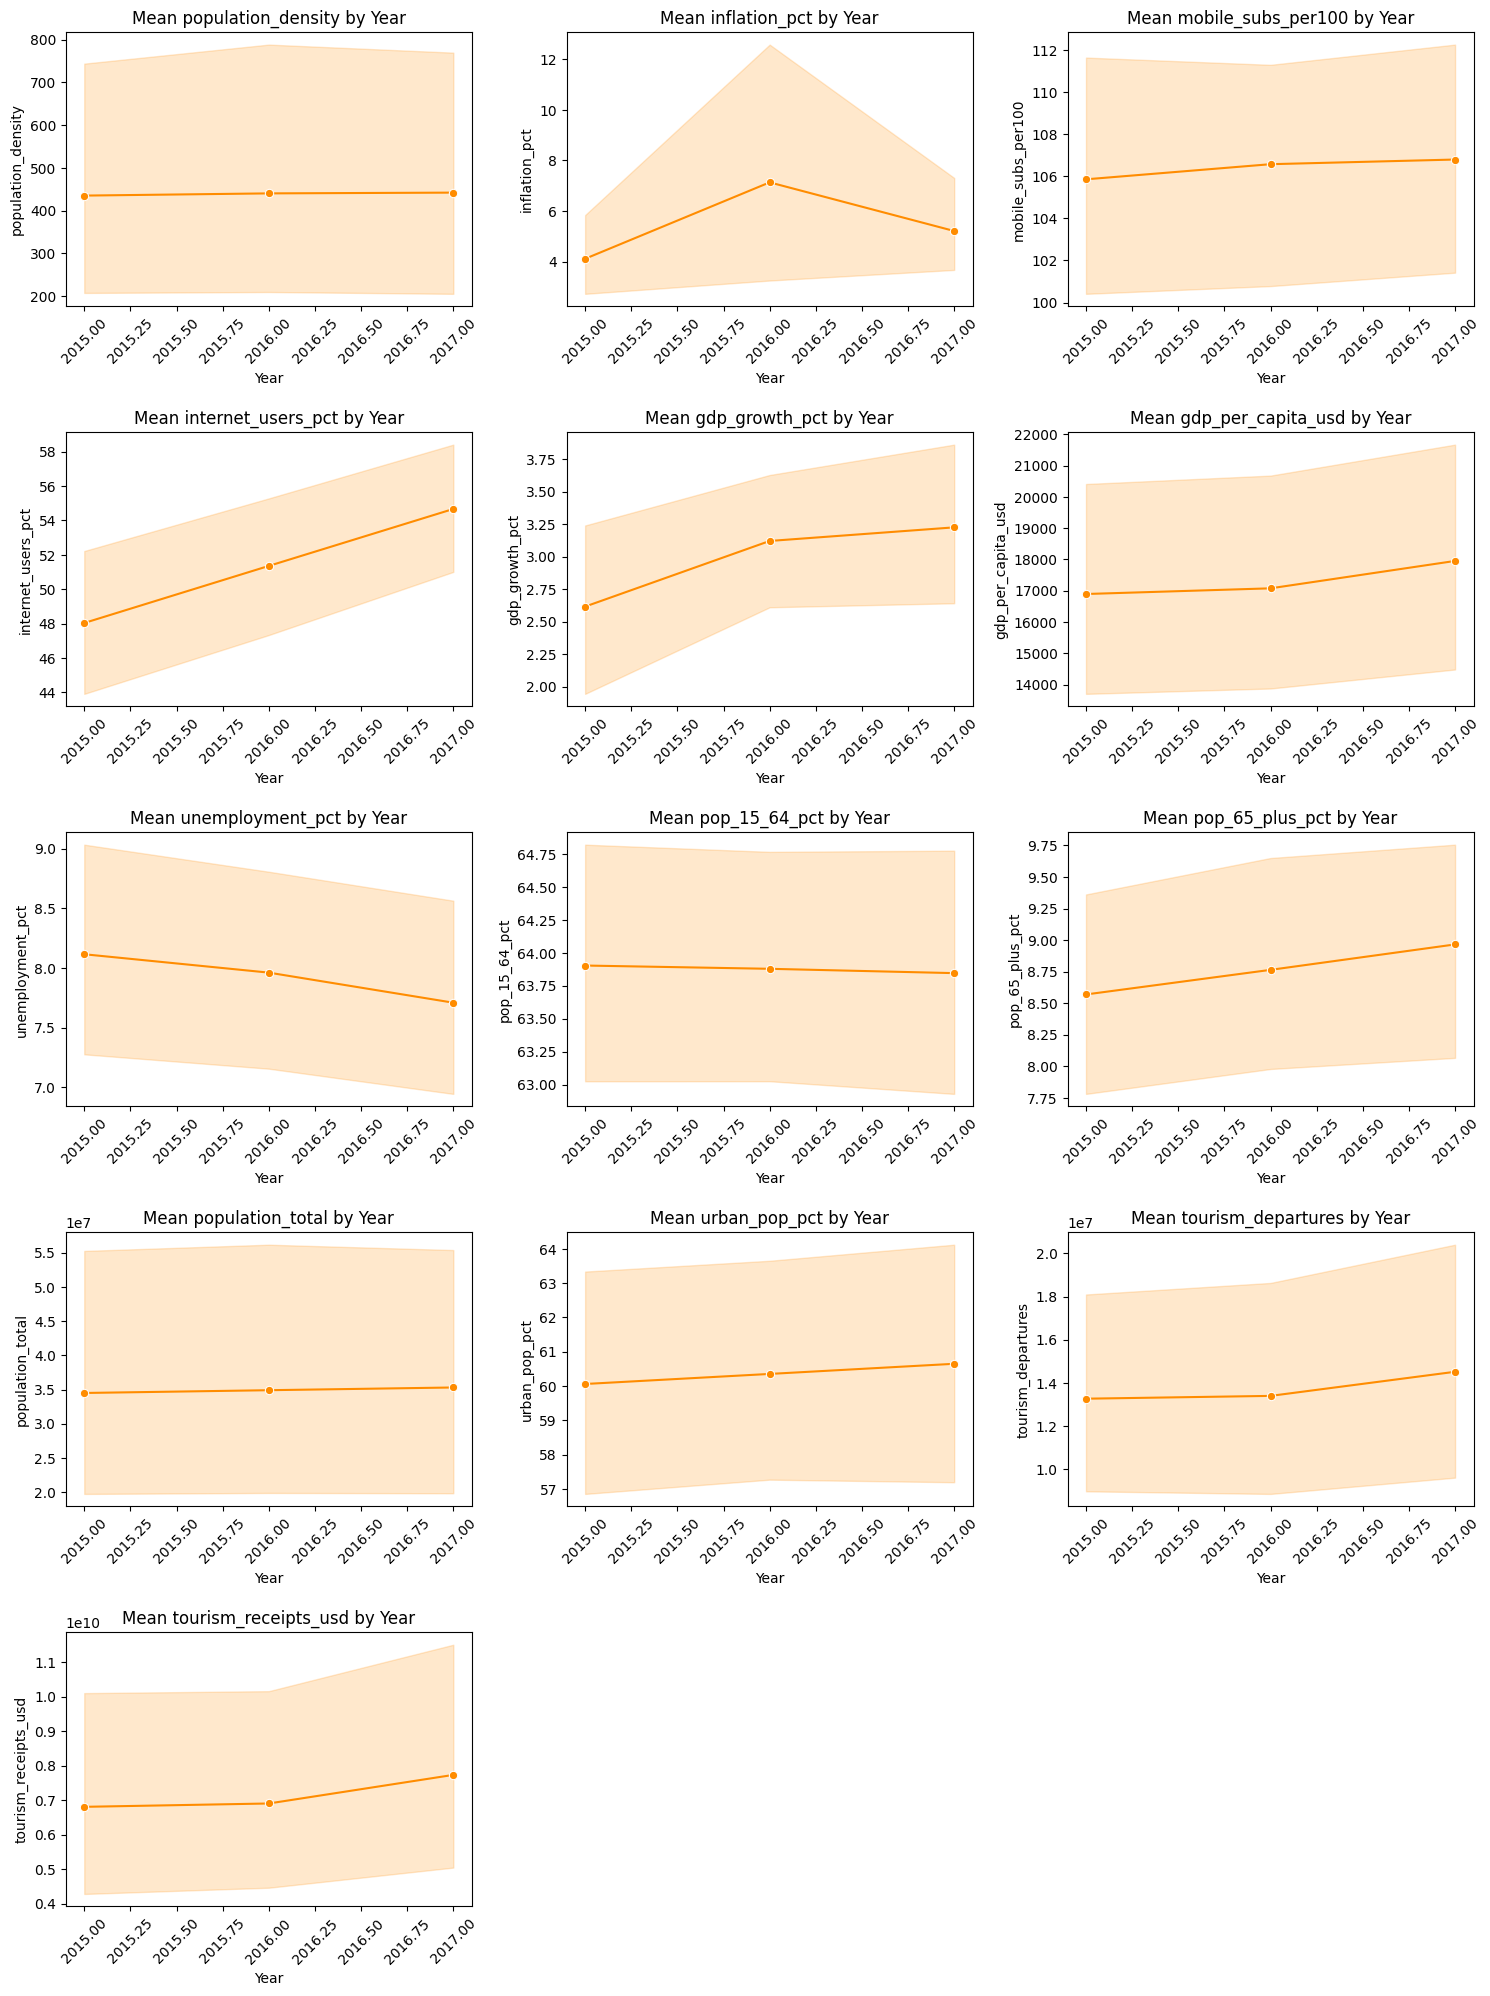

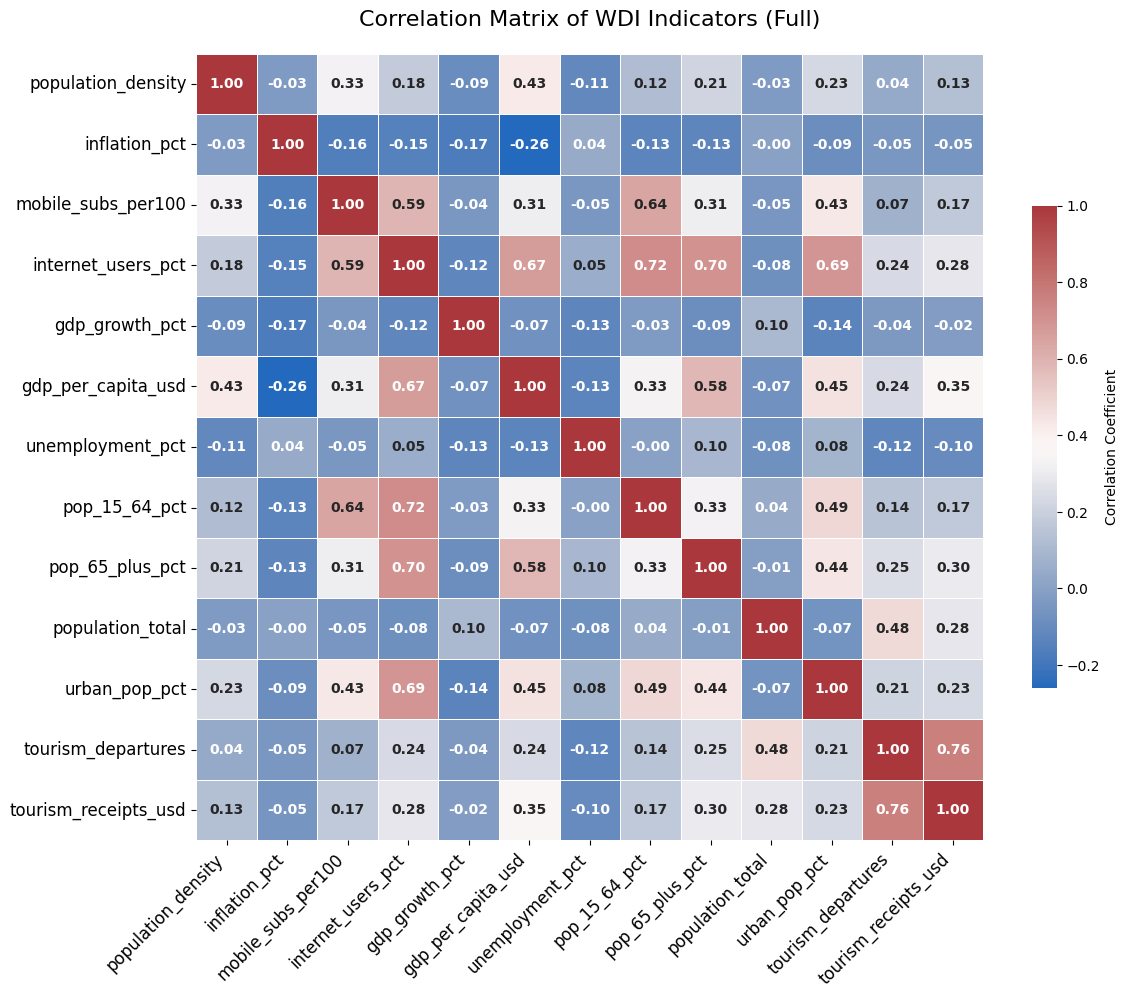

WDI wide shape: (645, 15)


,dtype,missing,unique
country,category,0,215
year,int16,0,3
population_density,float32,0,645
inflation_pct,float32,89,556
mobile_subs_per100,float32,32,613
internet_users_pct,float32,38,454
gdp_growth_pct,float32,23,620
gdp_per_capita_usd,float32,20,625
unemployment_pct,float32,87,545
pop_15_64_pct,float32,0,644



Final feature set ready for merging/modeling:
['country', 'year', 'population_density', 'inflation_pct', 'mobile_subs_per100', 'internet_users_pct', 'gdp_growth_pct', 'gdp_per_capita_usd', 'unemployment_pct', 'pop_15_64_pct', 'pop_65_plus_pct', 'population_total', 'urban_pop_pct', 'tourism_departures', 'tourism_receipts_usd']


,country,year,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd
0,ABW,2015,599.477783,0.474764,135.242722,88.699997,-0.623626,27458.224609,NaN,69.325089,11.640408,107906.0,43.108002,NaN,1.659000e+09
1,ABW,2016,604.038879,-0.931196,NaN,93.500000,1.719625,27441.529297,NaN,68.892082,12.163198,108727.0,43.192001,NaN,1.757000e+09
2,ABW,2017,604.083313,-1.028282,NaN,97.199997,7.048533,28440.052734,NaN,68.434845,12.716765,108735.0,43.292999,NaN,1.855000e+09
3,AFG,2015,51.870911,-0.661709,58.391094,8.260000,1.451315,565.569702,9.052,51.383968,2.356695,33831764.0,24.802999,NaN,8.600000e+07
4,AFG,2016,53.203030,4.383892,62.371098,11.000000,2.260314,522.082214,10.133,51.843056,2.355497,34700612.0,25.020000,NaN,6.200000e+07


In [ ]:
# Cleaning, EDA & Feature Engineering for WDI

# Cleaning & Harmonization
wdi_raw = datasets['wdi'].copy()

# Standardize column names
wdi = wdi_raw.rename(columns={
    'Country Name': 'country_name',
    'Country Code': 'country',
    'Indicator Name': 'indicator_name',
    'Indicator Code': 'indicator_code',
    'Year': 'year',
    'Value': 'value'
})

# Cast for efficiency
wdi['country'] = wdi['country'].astype('category')
wdi['year'] = wdi['year'].astype('category')

# Pivot to wide: one row per country & year
wdi_wide = (
    wdi
    .pivot(index=['country','year'],
           columns='indicator_code',
           values='value')
    .reset_index()
)
wdi_wide.columns.name = None

# Sort & cast year back to integer
wdi_wide.sort_values(['country','year'], inplace=True)
wdi_wide['year'] = wdi_wide['year'].astype(int)

# Manually map all 13 codes to concise names
manual_map = {
    'EN.POP.DNST':       'population_density',
    'SP.POP.TOTL':       'population_total',
    'SP.POP.1564.TO.ZS': 'pop_15_64_pct',
    'SP.POP.65UP.TO.ZS': 'pop_65_plus_pct',
    'SP.URB.TOTL.IN.ZS': 'urban_pop_pct',
    'NY.GDP.PCAP.CD':    'gdp_per_capita_usd',
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth_pct',
    'FP.CPI.TOTL.ZG':    'inflation_pct',
    'SL.UEM.TOTL.ZS':    'unemployment_pct',
    'IT.NET.USER.ZS':    'internet_users_pct',
    'IT.CEL.SETS.P2':    'mobile_subs_per100',
    'ST.INT.DPRT':       'tourism_departures',
    'ST.INT.RCPT.CD':    'tourism_receipts_usd'
}
wdi_wide.rename(columns=manual_map, inplace=True)

# Identify indicator columns
ind_cols = [c for c in wdi_wide.columns if c not in ('country','year')]

# EDA

# Missing-value summary (bar chart with labels)
fig, ax = plt.subplots(figsize=(8,6))
missing = wdi_wide[ind_cols].isna().sum().sort_values()
missing.plot.barh(ax=ax, color='steelblue')
ax.set_title("Missing Values by WDI Indicator", pad=12)
ax.set_xlabel("Count missing")
for i, v in enumerate(missing):
    ax.text(v + missing.max()*0.01, i, str(v), va='center')
plt.tight_layout()
plt.show()

# Distributions of each indicator
n = len(ind_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5*n_cols, 4*n_rows),
                         sharey=False)
axes = axes.flatten()
for ax, col in zip(axes, ind_cols):
    sns.histplot(wdi_wide[col].dropna(), kde=True, ax=ax, color='steelblue')
    ax.set_title(f"{col} distribution", fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
for ax in axes[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Mean trends over time
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5*n_cols, 4*n_rows),
                         sharey=False)
axes = axes.flatten()
for ax, col in zip(axes, ind_cols):
    sns.lineplot(data=wdi_wide, x='year', y=col,
                 estimator='mean', marker='o',
                 ax=ax, color='darkorange')
    ax.set_title(f"Mean {col} by Year", fontsize=12)
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel(col, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
for ax in axes[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = wdi_wide[ind_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    square=True,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.6, "label": "Correlation Coefficient"},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title("Correlation Matrix of WDI Indicators (Full)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Final downcast to save memory
wdi_wide = downcast_df(wdi_wide, int_only=False)

# Sanity check & feature list
print("WDI wide shape:", wdi_wide.shape)
with pd.option_context('display.max_rows', None):
    summary = (
        wdi_wide
        .dtypes
        .to_frame('dtype')
        .assign(
            missing=wdi_wide.isna().sum(),
            unique=wdi_wide.nunique()
        )
    )
    display(summary)

print("\nFinal feature set ready for merging/modeling:")
print(list(wdi_wide.columns))
display(wdi_wide.head())


**Cleaning, EDA & Feature Engineering for Hofstede**

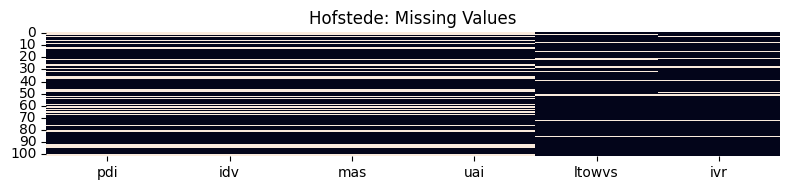

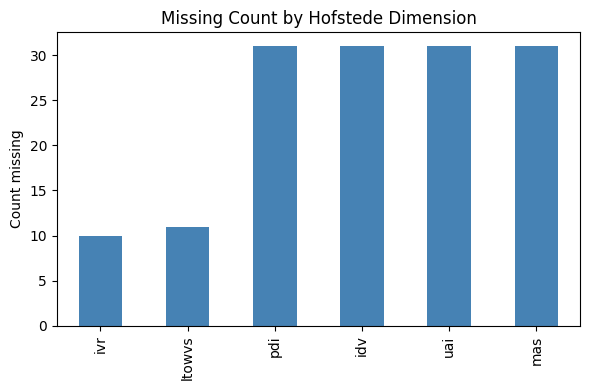

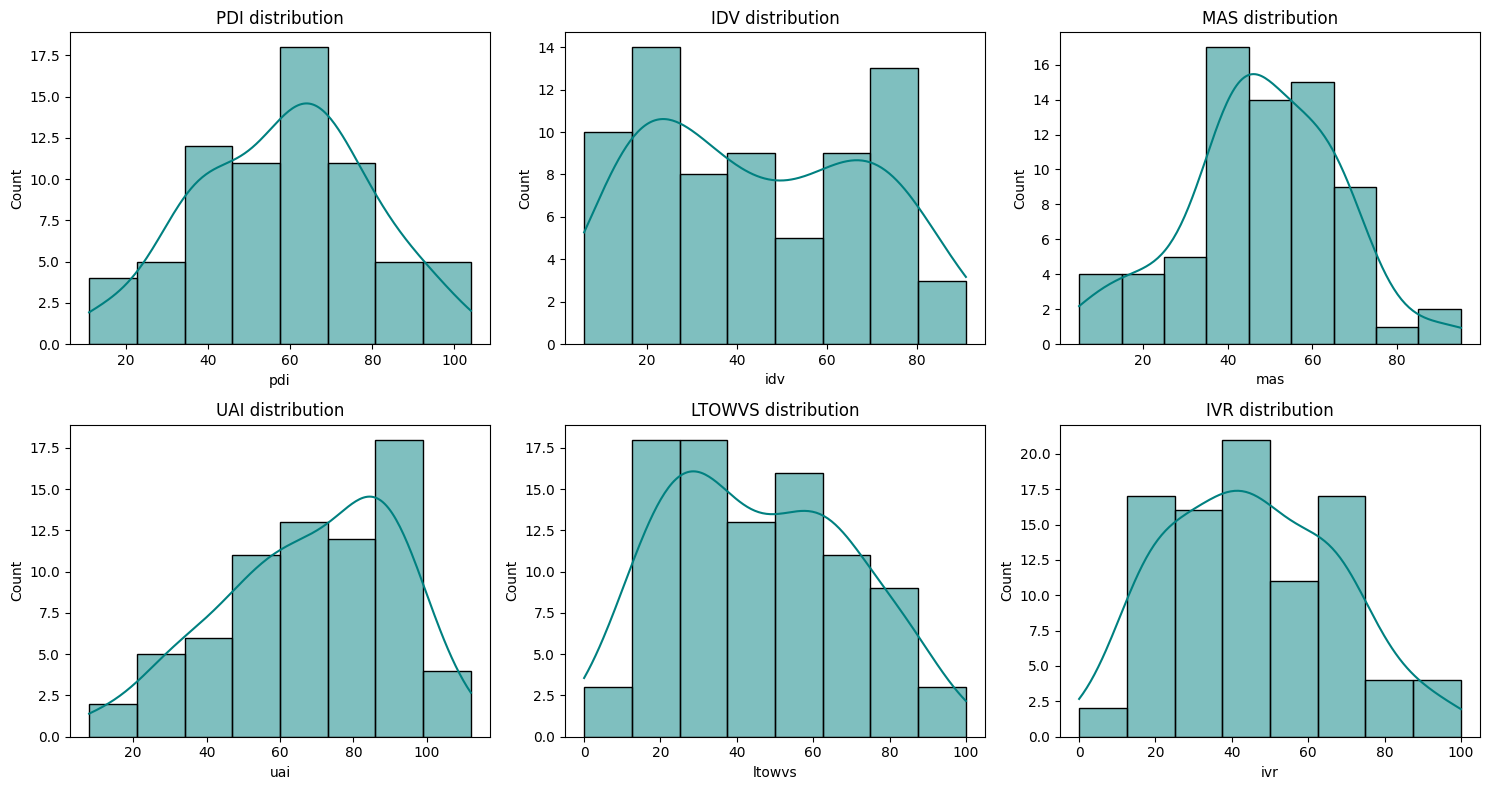

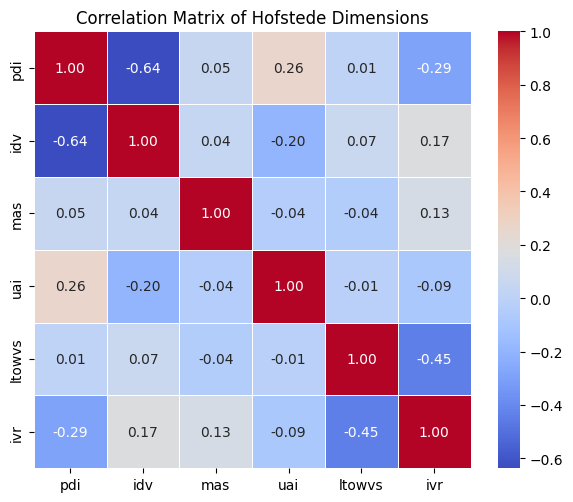

Hofstede sample rows:


,country,pdi,idv,mas,uai,ltowvs,ivr
0,ALB,NaN,NaN,NaN,NaN,61.460957,14.508928
1,AND,NaN,NaN,NaN,NaN,NaN,65.000000
2,ARG,49.0,46.0,56.0,86.0,20.403023,61.830357
3,ARM,NaN,NaN,NaN,NaN,60.957180,NaN
4,AUS,38.0,90.0,61.0,51.0,21.158689,71.428574



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
pdi,71.0,58.31,20.90,11.0,41.00,60.00,70.50,104.0
idv,71.0,44.80,24.36,6.0,21.50,41.00,67.50,91.0
mas,71.0,47.93,18.21,5.0,39.50,47.00,61.50,95.0
uai,71.0,68.06,23.67,8.0,50.50,70.00,86.00,112.0
ltowvs,91.0,45.58,23.98,0.0,25.82,45.34,62.72,100.0
ivr,92.0,45.56,22.38,0.0,28.96,43.86,63.49,100.0


Hofstede shape: (102, 7)


,dtype,missing,unique
country,category,0,102
pdi,float32,31,48
idv,float32,31,51
mas,float32,31,45
uai,float32,31,47
ltowvs,float32,11,84
ivr,float32,10,85


Final Hofstede features:
['country', 'pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']


In [ ]:
# Cleaning, EDA & Feature Engineering for Hofstede

# Cleaning & Harmonization
hof = datasets['hofstede'].copy()

# Rename for consistency and cast country
hof.rename(columns={'country_code': 'country'}, inplace=True)
hof.drop(columns=['country_name'], inplace=True)
hof['country'] = hof['country'].astype('category')

# Dimension columns
dim_cols = ['pdi','idv','mas','uai','ltowvs','ivr']

# Cast Hofstede scores to float32
hof[dim_cols] = hof[dim_cols].astype('float32')

# EDA

# Missing‐value heatmap
plt.figure(figsize=(8,2))
sns.heatmap(hof[dim_cols].isnull(), cbar=False)
plt.title("Hofstede: Missing Values")
plt.tight_layout()
plt.show()

# Missing‐count bar chart
missing = hof[dim_cols].isna().sum().sort_values()
plt.figure(figsize=(6,4))
missing.plot.bar(color='steelblue')
plt.title("Missing Count by Hofstede Dimension")
plt.ylabel("Count missing")
plt.tight_layout()
plt.show()

# Distributions
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()
for ax, col in zip(axes, dim_cols):
    sns.histplot(hof[col].dropna(), kde=True, ax=ax, color='teal')
    ax.set_title(f"{col.upper()} distribution")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = hof[dim_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix of Hofstede Dimensions")
plt.tight_layout()
plt.show()

# Sample rows & descriptive stats
print("Hofstede sample rows:")
display(hof.head())
print("\nNumeric summary:")
display(hof[dim_cols].describe().transpose().round(2))


# Feature Engineering
# Downcast six dimensions for efficiency

hof = downcast_df(hof, int_only=False)

# Final sanity check
print("Hofstede shape:", hof.shape)
summary = (
    hof.dtypes.to_frame('dtype')
       .assign(
           missing=hof.isna().sum(),
           unique=hof.nunique()
       )
)
display(summary)

print("Final Hofstede features:")
print(list(hof.columns))


**Data Integration**

In [ ]:
# Data Integration

wdi_cols = [
    'population_density','inflation_pct','mobile_subs_per100','internet_users_pct',
    'gdp_growth_pct','gdp_per_capita_usd','unemployment_pct','pop_15_64_pct',
    'pop_65_plus_pct','population_total','urban_pop_pct','tourism_departures',
    'tourism_receipts_usd'
]

hof_cols = ['pdi','idv','mas','uai','ltowvs','ivr']

# Country–Year aggregates
ext = country_year.copy()
print(f"Starting country_year shape: {ext.shape}")

# Align arrival_year type
ext['arrival_year'] = ext['arrival_year'].astype(int)

# LEFT-JOIN in all WDI columns
before_wdi = len(ext)
ext = (
    ext
    .merge(
        wdi_wide,
        left_on=['country','arrival_year'],
        right_on=['country','year'],
        how='left'
    )
    .drop(columns=['year'])
)
# Check and count how many country–years have >=1 missing WDI value
wdi_missing_cy = ext[wdi_cols].isna().any(axis=1).sum()
print(
    f"After left-join WDI: kept {len(ext)}/{before_wdi} rows"
    f":- {wdi_missing_cy} missing >=1 WDI ({wdi_missing_cy/before_wdi:.1%})"
)

# LEFT-JOIN in all Hofstede columns
before_hof = len(ext)
ext = ext.merge(hof, on='country', how='left')
# Check and count how many country–years have >=1 missing Hofstede dim
hof_missing_cy = ext[hof_cols].isna().any(axis=1).sum()
print(
    f"After left-join Hofstede: kept {len(ext)}/{before_hof} rows"
    f":- {hof_missing_cy} missing >=1 Hofstede ({hof_missing_cy/before_hof:.1%})"
)

print(f"Final external table shape: {ext.shape}\n")
display(ext.head(10))

# LEFT-JOIN back to booking-level (preserves every booking)
before_bk = len(bk)
bk_full = (
    bk
    .assign(arrival_year=lambda df: df['arrival_year'].astype(int))
    .merge(ext, on=['country','arrival_year'], how='left', suffixes=('','_ext'))
)
print(f"After left-join to bookings: kept {len(bk_full)}/{before_bk} bookings\n")

# Coverage check
total_bk = len(bk_full)
wdi_complete = bk_full[wdi_cols].notna().all(axis=1).sum()
hof_complete = bk_full[hof_cols].notna().all(axis=1).sum()
both_complete = bk_full[wdi_cols + hof_cols].notna().all(axis=1).sum()

print("Coverage in the left-joined bookings:")
print(f"All WDI data : {wdi_complete} / {total_bk} = {wdi_complete/total_bk:.1%}")
print(f"All Hofstede : {hof_complete} / {total_bk} = {hof_complete/total_bk:.1%}")
print(f"All external : {both_complete} / {total_bk} = {both_complete/total_bk:.1%}")

print(f"\nBooking-level merged table shape: {bk_full.shape}")
display(bk_full.head(10))


Starting country_year shape: (398, 4)
After left-join WDI: kept 398/398 rows:- 188 missing >=1 WDI (47.2%)
After left-join Hofstede: kept 398/398 rows:- 225 missing >=1 Hofstede (56.5%)
Final external table shape: (398, 23)



,country,arrival_year,bookings_count,cancellation_rate,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd,pdi,idv,mas,uai,ltowvs,ivr
0,ABW,2016,1,0.000000,604.038879,-0.931196,NaN,93.500000,1.719625,27441.529297,NaN,68.892082,12.163198,108727.0,43.192001,NaN,1.757000e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,2017,1,0.000000,604.083313,-1.028282,NaN,97.199997,7.048533,28440.052734,NaN,68.434845,12.716765,108735.0,43.292999,NaN,1.855000e+09,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,2015,50,0.080000,22.585865,9.355972,49.362450,22.000000,0.943572,3213.902588,16.490000,52.034416,2.691281,28157798.0,63.445999,NaN,1.171000e+09,NaN,NaN,NaN,NaN,NaN,NaN
3,AGO,2016,187,0.695187,23.408255,30.694414,44.593510,23.200001,-2.580050,1807.952881,16.575001,52.032383,2.685014,29183070.0,64.149002,NaN,6.280000e+08,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,2017,125,0.568000,24.251896,29.844481,44.106445,26.000000,-0.147213,2437.259766,16.610001,52.063931,2.685242,30234840.0,64.838997,NaN,8.840000e+08,NaN,NaN,NaN,NaN,NaN,NaN
5,AIA,2016,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ALB,2015,2,0.000000,105.135147,3.501208,117.987114,56.900002,2.218726,3952.803467,17.193001,68.463295,12.543106,2880703.0,57.433998,4504000.0,1.613000e+09,NaN,NaN,NaN,NaN,61.460957,14.508928
7,ALB,2016,6,0.333333,104.967186,-0.367317,116.962250,59.599998,3.314981,4124.055176,15.418000,68.473511,12.920212,2876101.0,58.421001,4852000.0,1.821000e+09,NaN,NaN,NaN,NaN,61.460957,14.508928
8,ALB,2017,4,0.000000,104.870697,2.060598,125.920525,62.400002,3.802599,4531.032227,13.616000,68.411255,13.305391,2873457.0,59.382999,5186000.0,2.050000e+09,NaN,NaN,NaN,NaN,61.460957,14.508928
9,AND,2016,3,0.666667,153.576599,NaN,104.951752,89.699997,3.709678,40129.820312,NaN,71.888229,13.017879,72181.0,88.248001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.000000


After left-join to bookings: kept 119390/119390 bookings

Coverage in the left-joined bookings:
All WDI data : 93258 / 119390 = 78.1%
All Hofstede : 116609 / 119390 = 97.7%
All external : 91892 / 119390 = 77.0%

Booking-level merged table shape: (119390, 62)


,hotel,is_canceled,lead_time,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_year,total_nights,total_guests,cancel_lag,lead_time_bin,season,is_long_stay,flag_repeated_guest,flag_special_requests,flag_deposit_taken,flag_country_unknown,flag_lead_time_outlier,flag_cancel_lag_outlier,flag_negative_adr,flag_adr_outlier,bookings_count,cancellation_rate,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd,pdi,idv,mas,uai,ltowvs,ivr
0,Resort Hotel,0,342,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NONE,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015,0,2,0,>180d,Summer,0,0,0,0,0,0,0,0,0,13307,0.569775,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,63.0,27.0,31.0,104.0,28.211586,33.25893
1,Resort Hotel,0,737,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NONE,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015,0,2,0,>180d,Summer,0,0,0,0,0,1,0,0,0,13307,0.569775,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,63.0,27.0,31.0,104.0,28.211586,33.25893
2,Resort Hotel,0,7,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NONE,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015,1,1,-1,0-7d,Summer,0,0,0,0,0,0,0,0,0,1356,0.084808,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,NaN,35.0,89.0,66.0,35.0,51.133503,69.41964
3,Resort Hotel,0,13,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015,1,1,-1,8-30d,Summer,0,0,0,0,0,0,0,0,0,1356,0.084808,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,NaN,35.0,89.0,66.0,35.0,51.133503,69.41964
4,Resort Hotel,0,14,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015,2,2,-2,8-30d,Summer,0,0,1,0,0,0,0,0,0,1356,0.084808,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,NaN,35.0,89.0,66.0,35.0,51.133503,69.41964
5,Resort Hotel,0,14,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015,2,2,-2,8-30d,Summer,0,0,1,0,0,0,0,0,0,1356,0.084808,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,NaN,35.0,89.0,66.0,35.0,51.133503,69.41964
6,Resort Hotel,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NONE,0,Transient,107.0,0,0,Check-Out,2015-07-03,2015-07-01,2015,2,2,-2,0-7d,Summer,0,0,0,0,0,0,0,0,0,13307,0.569775,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,63.0,27.0,31.0,104.0,28.211586,33.25893
7,Resort Hotel,0,9,2,0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03,2015-07-01,2015,2,2,-2,8-30d,Summer,0,0,1,0,0,0,0,0,0,13307,0.569775,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,63.0,27.0,31.0,104.0,28.211586,33.25893
8,Resort Hotel,1,85,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,82.0,0,1,Canceled,2015-05-06,2015-07-01,2015,3,2,56,31-90d,Summer,0,0,1,0,0,0,0,0,0,13307,0.569775,113.072517,0.487939,113.016884,68.599998

**Comprehensive Overview of the Merged Booking-Level Dataset**

In [ ]:
# Comprehensive Overview of the Merged Booking-Level Dataset

# Quick shape & memory usage
rows, cols = bk_full.shape
mem_mb = bk_full.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Dataset shape: {rows:,} rows × {cols:,} columns")
print(f"Total memory usage: {mem_mb:.2f} MB\n")

# DataFrame schema & non-null counts
print("DataFrame info:")
bk_full.info(verbose=True, show_counts=True)
print()

# Column-level summary
pd.set_option('display.max_rows', None)
col_stats = pd.DataFrame({
    'dtype': bk_full.dtypes,
    'missing': bk_full.isna().sum(),
    'pct_missing': (bk_full.isna().mean() * 100).map('{:.1f}%'.format),
    'unique': bk_full.nunique()
})
print("Column overview:")
display(col_stats.style.set_caption("dtype | missing | % missing | unique"))

# Numeric features: descriptive statistics
num_summary = bk_full.select_dtypes(include=[np.number]).describe().T
print("\nNumeric features summary:")
display(num_summary)

# Categorical features: top 10 levels
cat_cols = bk_full.select_dtypes(include=['category', 'object']).columns
print("\nTop categories (up to 10) per categorical column:")
for col in cat_cols:
    freqs = bk_full[col].value_counts(dropna=False).head(10)
    table = [(idx, cnt) for idx, cnt in freqs.items()]
    print(f"\n{col!r}:")
    print(tabulate(table, headers=[col, 'count'], tablefmt='psql'))


Dataset shape: 119,390 rows × 62 columns
Total memory usage: 25.07 MB

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 62 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  category      
 1   is_canceled                     119390 non-null  int8          
 2   lead_time                       119390 non-null  int16         
 3   adults                          119390 non-null  int8          
 4   children                        119390 non-null  uint8         
 5   babies                          119390 non-null  int8          
 6   meal                            119390 non-null  category      
 7   country                         119390 non-null  object        
 8   market_segment                  119390 non-null  category      
 9   distribution_channel            119390

,dtype,missing,pct_missing,unique
hotel,category,0,0.0%,2
is_canceled,int8,0,0.0%,2
lead_time,int16,0,0.0%,479
adults,int8,0,0.0%,14
children,uint8,0,0.0%,5
babies,int8,0,0.0%,5
meal,category,0,0.0%,5
country,object,0,0.0%,177
market_segment,category,0,0.0%,8
distribution_channel,category,0,0.0%,5



Numeric features summary:


,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,3.704163e-01,4.829182e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
lead_time,119390.0,1.040114e+02,1.068631e+02,0.000000e+00,1.800000e+01,6.900000e+01,1.600000e+02,7.370000e+02
adults,119390.0,1.856403e+00,5.792610e-01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.500000e+01
children,119390.0,1.038864e-01,3.985552e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
babies,119390.0,7.948739e-03,9.743619e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
is_repeated_guest,119390.0,3.191222e-02,1.757671e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
previous_cancellations,119390.0,8.711785e-02,8.443364e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01
previous_bookings_not_canceled,119390.0,1.370969e-01,1.497437e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.200000e+01
booking_changes,119390.0,2.211240e-01,6.523056e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01
days_in_waiting_list,119390.0,2.321149e+00,1.759472e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.910000e+02



Top categories (up to 10) per categorical column:

'hotel':
+--------------+---------+
| hotel        |   count |
|--------------+---------|
| City Hotel   |   79330 |
| Resort Hotel |   40060 |
+--------------+---------+

'meal':
+-----------+---------+
| meal      |   count |
|-----------+---------|
| BB        |   92310 |
| HB        |   14463 |
| SC        |   10650 |
| Undefined |    1169 |
| FB        |     798 |
+-----------+---------+

'country':
+-----------+---------+
| country   |   count |
|-----------+---------|
| PRT       |   48590 |
| GBR       |   12129 |
| FRA       |   10415 |
| ESP       |    8568 |
| DEU       |    7287 |
| ITA       |    3766 |
| IRL       |    3375 |
| BEL       |    2342 |
| CHN       |    2278 |
| BRA       |    2224 |
+-----------+---------+

'market_segment':
+------------------+---------+
| market_segment   |   count |
|------------------+---------|
| Online TA        |   56477 |
| Offline TA/TO    |   24219 |
| Groups           |   19811 |

**Import UNSD Dataset For Regions**

In [ ]:
df = pd.read_csv("UNSD.csv", sep=";", nrows=5)
print(df.columns.tolist())

# Load the ISO-alpha3 and Region Name columns
unsd = pd.read_csv(
    "UNSD.csv",
    sep=";",
    usecols=["ISO-alpha3 Code", "Region Name"]
)

# Rename to match the joins
unsd.rename(
    columns={
        "ISO-alpha3 Code": "country",
        "Region Name": "region"
    },
    inplace=True
)

print(unsd.head())

['Global Code', 'Global Name', 'Region Code', 'Region Name', 'Sub-region Code', 'Sub-region Name', 'Intermediate Region Code', 'Intermediate Region Name', 'Country or Area', 'M49 Code', 'ISO-alpha2 Code', 'ISO-alpha3 Code', 'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)']
   region country
0  Africa     DZA
1  Africa     EGY
2  Africa     LBY
3  Africa     MAR
4  Africa     SDN


**Impute Missing WDI Features**

In [ ]:
# Impute Missing WDI Features

ext_wdi = ext.copy()

# Flag original missing‐any at country–year level
ext_wdi['wdi_missing_orig'] = ext_wdi[wdi_cols].isna().any(axis=1).astype('uint8')
cy_missing_orig = int(ext_wdi['wdi_missing_orig'].sum())

# Build booking‐level helper for flags
bk_helper = bk_full[['country','arrival_year']].copy()
bk_helper['bk_missing_orig'] = (
    bk_helper
    .merge(
      ext_wdi[['country','arrival_year','wdi_missing_orig']],
      on=['country','arrival_year'], how='left'
    )['wdi_missing_orig']
    .fillna(0).astype('uint8')
)
bk_missing_orig = int(bk_helper['bk_missing_orig'].sum())

print("Before any imputation:")
print(f"Country–years missing >=1 WDI: {cy_missing_orig}/{len(ext_wdi)}")
print(f"Bookings missing >=1 WDI: {bk_missing_orig}/{len(bk_helper)}\n")

# 1: Per-country linear interpolate + ffill + bfill
ext_wdi = ext_wdi.sort_values(['country','arrival_year'])
for col in wdi_cols:
    grp = ext_wdi.groupby('country')[col]
    ext_wdi[col] = (
        grp.transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
           .fillna(grp.transform('ffill'))
           .fillna(grp.transform('bfill'))
    )
ext_wdi['wdi_missing_after1'] = ext_wdi[wdi_cols].isna().any(axis=1).astype('uint8')

print("After interp + ffill/bfill:")
print(f"Country–years still missing >=1 WDI: {ext_wdi['wdi_missing_after1'].sum()}/{len(ext_wdi)}\n")

# 2: region–year median fill
unsd = pd.read_csv(
    "UNSD.csv",
    sep=";",
    usecols=["ISO-alpha3 Code","Region Name"]
).rename(columns={
    "ISO-alpha3 Code":"country",
    "Region Name":"region"
})
ext_wdi = ext_wdi.merge(unsd, on="country", how="left")

region_year_meds = (
    ext_wdi
    .groupby(['region','arrival_year'])[wdi_cols]
    .median()
)
ext_wdi = (
    ext_wdi
    .merge(region_year_meds,
           how="left",
           left_on=['region','arrival_year'],
           right_index=True,
           suffixes=("","_rymed"))
)
for col in wdi_cols:
    ext_wdi[col] = ext_wdi[col].fillna(ext_wdi[f"{col}_rymed"])
# drop temp columns
ext_wdi.drop(columns=[f"{c}_rymed" for c in wdi_cols], inplace=True)

ext_wdi['wdi_missing_after2'] = ext_wdi[wdi_cols].isna().any(axis=1).astype('uint8')
print("After region-year median fill:")
print(f"Country–years still missing >=1 WDI: {ext_wdi['wdi_missing_after2'].sum()}/{len(ext_wdi)}\n")

# 2: year-median fill for the ones that remain
year_meds = ext_wdi.groupby('arrival_year')[wdi_cols].median()
mask = ext_wdi['wdi_missing_after2'] == 1
for col in wdi_cols:
    ext_wdi.loc[mask, col] = ext_wdi.loc[mask, col].fillna(
        ext_wdi.loc[mask, 'arrival_year'].map(year_meds[col])
    )
ext_wdi['wdi_missing_after3'] = ext_wdi[wdi_cols].isna().any(axis=1).astype('uint8')
print("After region-year + year-median fill:")
print(f"Country–years still missing >=1 WDI: {ext_wdi['wdi_missing_after3'].sum()}/{len(ext_wdi)}\n")

# 3: global-median safety net
if ext_wdi['wdi_missing_after3'].any():
    global_meds = ext_wdi[wdi_cols].median()
    ext_wdi[wdi_cols] = ext_wdi[wdi_cols].fillna(global_meds)
    ext_wdi['wdi_missing_after4'] = ext_wdi[wdi_cols].isna().any(axis=1).astype('uint8')
    print("After global-median fill:")
    print(f"Country–years still missing >=1 WDI: {ext_wdi['wdi_missing_after4'].sum()}/{len(ext_wdi)}\n")
    final_flag = 'wdi_missing_after4'
    stages = ['orig','after1','after2','after3','after4']
else:
    final_flag = 'wdi_missing_after3'
    stages = ['orig','after1','after2','after3']

# Final cast
ext_wdi[wdi_cols] = ext_wdi[wdi_cols].astype('float32')

# Recompute all booking-level flags
flag_df = ext_wdi.set_index(['country','arrival_year'])[
    ['wdi_missing_orig','wdi_missing_after1','wdi_missing_after2',final_flag]
]
for stage in stages:
    bk_helper[f"bk_missing_{stage}"] = (
        bk_helper[['country','arrival_year']]
        .apply(lambda r: flag_df.loc[(r.country,r.arrival_year), f"wdi_missing_{stage}"], axis=1)
        .astype('uint8')
    )

# Merge imputed WDI + final flag back into bk_full
ext_wdi['booking_wdi_imputed'] = ext_wdi['wdi_missing_orig']
bk_full = (
    bk_full
    .drop(columns=wdi_cols, errors='ignore')
    .merge(
        ext_wdi[['country','arrival_year'] + wdi_cols + ['booking_wdi_imputed']],
        on=['country','arrival_year'], how='left'
    )
)
print("Final flag in bk_full = booking_wdi_imputed")
print(f"Bookings flagged as imputed: {bk_full['booking_wdi_imputed'].sum()} / {len(bk_full)}\n")

# Imputation summary table
summary = pd.DataFrame({
    'step': stages,
    'cy_missing': [ cy_missing_orig ] +
                  [ int(ext_wdi[f"wdi_missing_after{i}"].sum()) for i in range(1, len(stages)) ],
    'bk_missing': [ int(bk_helper['bk_missing_' + s].sum()) for s in stages ]
})
summary['cy_filled'] = summary['cy_missing'].shift(1, fill_value=summary.loc[0,'cy_missing']) - summary['cy_missing']
summary['bk_filled'] = summary['bk_missing'].shift(1, fill_value=summary.loc[0,'bk_missing']) - summary['bk_missing']
print("Imputation summary:")
display(summary)

print("Sample ext_wdi:")
display(ext_wdi[['country','region','arrival_year'] + wdi_cols +
                ['wdi_missing_orig','wdi_missing_after1','wdi_missing_after2',final_flag,
                 'booking_wdi_imputed']].head(10))

print("Sample bk_full bookings:")
display(
    bk_full
    .loc[bk_full['booking_wdi_imputed']==1,
         ['country','arrival_year','booking_wdi_imputed'] + wdi_cols]
    .head(10)
)


Before any imputation:
Country–years missing >=1 WDI: 188/398
Bookings missing >=1 WDI: 26132/119390

After interp + ffill/bfill:
Country–years still missing >=1 WDI: 183/398

After region-year median fill:
Country–years still missing >=1 WDI: 8/398

After region-year + year-median fill:
Country–years still missing >=1 WDI: 0/398

Final flag in bk_full = booking_wdi_imputed
Bookings flagged as imputed: 26132 / 119390

Imputation summary:


,step,cy_missing,bk_missing,cy_filled,bk_filled
0,orig,188,26132,0,0
1,after1,183,26080,5,52
2,after2,8,541,175,25539
3,after3,0,0,8,541


Sample ext_wdi:


,country,region,arrival_year,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd,wdi_missing_orig,wdi_missing_after1,wdi_missing_after2,wdi_missing_after3,booking_wdi_imputed
0,ABW,Americas,2016,604.038879,-0.931196,117.986977,93.500000,1.719625,27441.529297,6.727000,68.892082,12.163198,108727.0,43.192001,1516500.0,1.757000e+09,1,1,0,0,1
1,ABW,Americas,2017,604.083313,-1.028282,119.032822,97.199997,7.048533,28440.052734,6.138000,68.434845,12.716765,108735.0,43.292999,1668500.0,1.855000e+09,1,1,0,0,1
2,AGO,Africa,2015,22.585865,9.355972,49.362450,22.000000,0.943572,3213.902588,16.490000,52.034416,2.691281,28157798.0,63.445999,1910000.0,1.171000e+09,1,1,0,0,1
3,AGO,Africa,2016,23.408255,30.694414,44.593510,23.200001,-2.580050,1807.952881,16.575001,52.032383,2.685014,29183070.0,64.149002,1199000.0,6.280000e+08,1,1,0,0,1
4,AGO,Africa,2017,24.251896,29.844481,44.106445,26.000000,-0.147213,2437.259766,16.610001,52.063931,2.685242,30234840.0,64.838997,1056500.0,8.840000e+08,1,1,0,0,1
5,AIA,Americas,2016,58.623535,2.537817,117.986977,58.849998,1.953417,8194.502930,6.727000,65.412323,7.393576,6240896.0,70.190498,1516500.0,2.732500e+09,1,1,0,0,1
6,ALB,Europe,2015,105.135147,3.501208,117.987114,56.900002,2.218726,3952.803467,17.193001,68.463295,12.543106,2880703.0,57.433998,4504000.0,1.613000e+09,0,0,0,0,0
7,ALB,Europe,2016,104.967186,-0.367317,116.962250,59.599998,3.314981,4124.055176,15.418000,68.473511,12.920212,2876101.0,58.421001,4852000.0,1.821000e+09,0,0,0,0,0
8,ALB,Europe,2017,104.870697,2.060598,125.920525,62.400002,3.802599,4531.032227,13.616000,68.411255,13.305391,2873457.0,59.382999,5186000.0,2.050000e+09,0,0,0,0,0
9,AND,Europe,2016,153.576599,0.270417,104.951752,89.699997,3.709678,40129.820312,7.702500,71.888229,13.017879,72181.0,88.248001,8995500.0,7.041000e+09,1,1,0,0,1


Sample bk_full bookings:


,country,arrival_year,booking_wdi_imputed,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd
2,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
3,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
4,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
5,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
13,ESP,2015,1,92.952682,-0.500366,109.985558,78.699997,4.060867,25969.837891,22.056999,66.461456,18.541754,46444832.0,79.601997,17625000.0,6.766000e+09
19,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
20,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
24,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09
30,UNK,2015,1,92.494736,0.798631,118.001610,65.750000,2.629730,10623.058594,6.842500,66.138489,10.623894,11338230.0,70.047501,6091000.0,5.722500e+09
31,GBR,2015,1,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517000,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09


In [ ]:
# Verification

ext_after1 = ext.copy()
# run only the interpolation + ffill/bfill loop
ext_after1 = ext_after1.sort_values(['country','arrival_year'])
for col in wdi_cols:
    grp = ext_after1.groupby('country')[col]
    ext_after1[col] = (
        grp.transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
           .fillna(grp.transform('ffill'))
           .fillna(grp.transform('bfill'))
    )
ext_after1['wdi_missing_after1'] = ext_after1[wdi_cols].isna().any(axis=1)

# Compute the region–year medians
unsd = pd.read_csv("UNSD.csv", sep=";", usecols=["ISO-alpha3 Code","Region Name"])\
          .rename(columns={"ISO-alpha3 Code":"country","Region Name":"region"})
ext_after1 = ext_after1.merge(unsd, on="country", how="left")
region_year_meds = (
    ext_after1
    .groupby(['region','arrival_year'])[wdi_cols]
    .median()
)

mask_cy2 = (ext_after1['wdi_missing_after1']) & \
           (~ext_wdi['wdi_missing_after2'])
cy2 = ext_after1.loc[mask_cy2, ['country','arrival_year','region'] + wdi_cols]

# Verify each column that was missing got set to the median
errors = []
for idx, row in cy2.iterrows():
    cntry, yr, reg = row['country'], row['arrival_year'], row['region']
    for col in wdi_cols:
        # only test columns that were NaN in ext_after1
        if pd.isna(ext_after1.loc[idx, col]):
            actual   = ext_wdi.loc[idx, col]
            expected = region_year_meds.loc[(reg,yr), col]
            if not np.isclose(actual, expected, atol=1e-6):
                errors.append((cntry, yr, col, actual, expected))

if not errors:
    print("Region–year median fill is all good, only the originally missing WDI columns were replaced by the region–year medians")
else:
    print("Discrepancies found in region–year fill:")
    for e in errors[:10]:
        print(f"Country={e[0]} Year={e[1]} Col={e[2]}  got={e[3]} expected={e[4]}")


Region–year median fill is all good, only the originally missing WDI columns were replaced by the region–year medians


**Inter-Indicator Ratios - WDI**

In [ ]:
# Inter-Indicator Ratios

# country-year key
ratios = ext_wdi[['country','arrival_year']].copy()

# Tourism departures per 1,000 people
denom_pop = ext_wdi['population_total'].replace(0, np.nan)
ratios['tourism_departures_per_1000'] = (
    ext_wdi['tourism_departures'] / (denom_pop / 1_000)
)

# Tourism receipts per capita & share of GDP
ratios['tourism_receipts_per_capita'] = (
    ext_wdi['tourism_receipts_usd'] / denom_pop
)
denom_gdp = (ext_wdi['gdp_per_capita_usd'] * denom_pop).replace(0, np.nan)
ratios['tourism_share_of_gdp'] = (
    ext_wdi['tourism_receipts_usd'] / denom_gdp
)

# Real GDP growth = nominal % – inflation %
ratios['real_gdp_growth_pct'] = (
    ext_wdi['gdp_growth_pct'] - ext_wdi['inflation_pct']
)

# Digital penetration = avg of Internet % and mobile subs
ratios['digital_penetration_index'] = (
    (ext_wdi['internet_users_pct'] + ext_wdi['mobile_subs_per100']) / 2
)

# Dependency ratio stuff
ratios['pop_0_14_pct'] = (
    100 - ext_wdi['pop_15_64_pct'] - ext_wdi['pop_65_plus_pct']
).clip(0)
denom_work = ext_wdi['pop_15_64_pct'].replace(0, np.nan)
ratios['dependency_ratio'] = ratios['pop_0_14_pct'] / denom_work

# Cast & round
ratio_cols = [c for c in ratios.columns if c not in ('country','arrival_year')]
ratios[ratio_cols] = ratios[ratio_cols].astype('float32').round(3)

# Merge into booking table
bk_full = bk_full.merge(ratios, on=['country','arrival_year'], how='left')

# Sanity check
missing = bk_full[ratio_cols].isna().sum()
pct = missing / len(bk_full)
sanity = pd.DataFrame({'missing': missing, 'pct_missing': pct})
print("New ratio features in bk_full:")
display(sanity)

print("\nSample of bk_full:")
display(bk_full.head())


New ratio features in bk_full:


,missing,pct_missing
tourism_departures_per_1000,0,0.0
tourism_receipts_per_capita,0,0.0
tourism_share_of_gdp,0,0.0
real_gdp_growth_pct,0,0.0
digital_penetration_index,0,0.0
pop_0_14_pct,0,0.0
dependency_ratio,0,0.0



Sample of bk_full:


,hotel,is_canceled,lead_time,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_year,total_nights,total_guests,cancel_lag,lead_time_bin,season,is_long_stay,flag_repeated_guest,flag_special_requests,flag_deposit_taken,flag_country_unknown,flag_lead_time_outlier,flag_cancel_lag_outlier,flag_negative_adr,flag_adr_outlier,bookings_count,cancellation_rate,pdi,idv,mas,uai,ltowvs,ivr,population_density,inflation_pct,mobile_subs_per100,internet_users_pct,gdp_growth_pct,gdp_per_capita_usd,unemployment_pct,pop_15_64_pct,pop_65_plus_pct,population_total,urban_pop_pct,tourism_departures,tourism_receipts_usd,booking_wdi_imputed,tourism_departures_per_1000,tourism_receipts_per_capita,tourism_share_of_gdp,real_gdp_growth_pct,digital_penetration_index,pop_0_14_pct,dependency_ratio
0,Resort Hotel,0,342,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NONE,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015,0,2,0,>180d,Summer,0,0,0,0,0,0,0,0,0,13307,0.569775,63.0,27.0,31.0,104.0,28.211586,33.25893,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,0,182.755997,1545.364014,0.080,1.102,90.807999,14.299000,0.220
1,Resort Hotel,0,737,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NONE,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015,0,2,0,>180d,Summer,0,0,0,0,0,1,0,0,0,13307,0.569775,63.0,27.0,31.0,104.0,28.211586,33.25893,113.072517,0.487939,113.016884,68.599998,1.589798,19215.781250,12.447,65.126991,20.574253,10358076.0,63.514000,1893000.0,1.600700e+10,0,182.755997,1545.364014,0.080,1.102,90.807999,14.299000,0.220
2,Resort Hotel,0,7,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NONE,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015,1,1,-1,0-7d,Summer,0,0,0,0,0,0,0,0,0,1356,0.084808,35.0,89.0,66.0,35.0,51.133503,69.41964,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09,1,1192.006958,103.906998,0.002,1.855,106.751999,17.881001,0.278
3,Resort Hotel,0,13,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015,1,1,-1,8-30d,Summer,0,0,0,0,0,0,0,0,0,1356,0.084808,35.0,89.0,66.0,35.0,51.133503,69.41964,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09,1,1192.006958,103.906998,0.002,1.855,106.751999,17.881001,0.278
4,Resort Hotel,0,14,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015,2,2,-2,8-30d,Summer,0,0,1,0,0,0,0,0,0,1356,0.084808,35.0,89.0,66.0,35.0,51.133503,69.41964,269.153137,0.368047,121.504890,92.000000,2.222888,44964.390625,5.517,64.349419,17.769979,65116220.0,82.625999,77619000.0,6.766000e+09,1,1192.006958,103.906998,0.002,1.855,106.751999,17.881001,0.278


**Hofstede Imputation**


--- Hofstede imputation summary ---


,step,cy_missing,bk_missing,cy_filled,bk_filled
0,orig,40,2781,0,0
1,after PMM-MICE,0,1435,40,1346
2,after region median,0,490,0,945



Sanity check: original vs imputed (ITA, BRA, JPN):

ITA:
original: {'pdi': 50.0, 'idv': 76.0, 'mas': 70.0, 'uai': 75.0, 'ltowvs': 61.46095657348633, 'ivr': 29.6875}
imputed : {'pdi': 50, 'idv': 76, 'mas': 70, 'uai': 75, 'ltowvs': 61, 'ivr': 30}

BRA:
original: {'pdi': 69.0, 'idv': 38.0, 'mas': 49.0, 'uai': 76.0, 'ltowvs': 43.82871627807617, 'ivr': 59.15178680419922}
imputed : {'pdi': 69, 'idv': 38, 'mas': 49, 'uai': 76, 'ltowvs': 44, 'ivr': 59}

JPN:
original: {'pdi': 54.0, 'idv': 46.0, 'mas': 95.0, 'uai': 92.0, 'ltowvs': 87.90931701660156, 'ivr': 41.74106979370117}
imputed : {'pdi': 54, 'idv': 46, 'mas': 95, 'uai': 92, 'ltowvs': 88, 'ivr': 42}


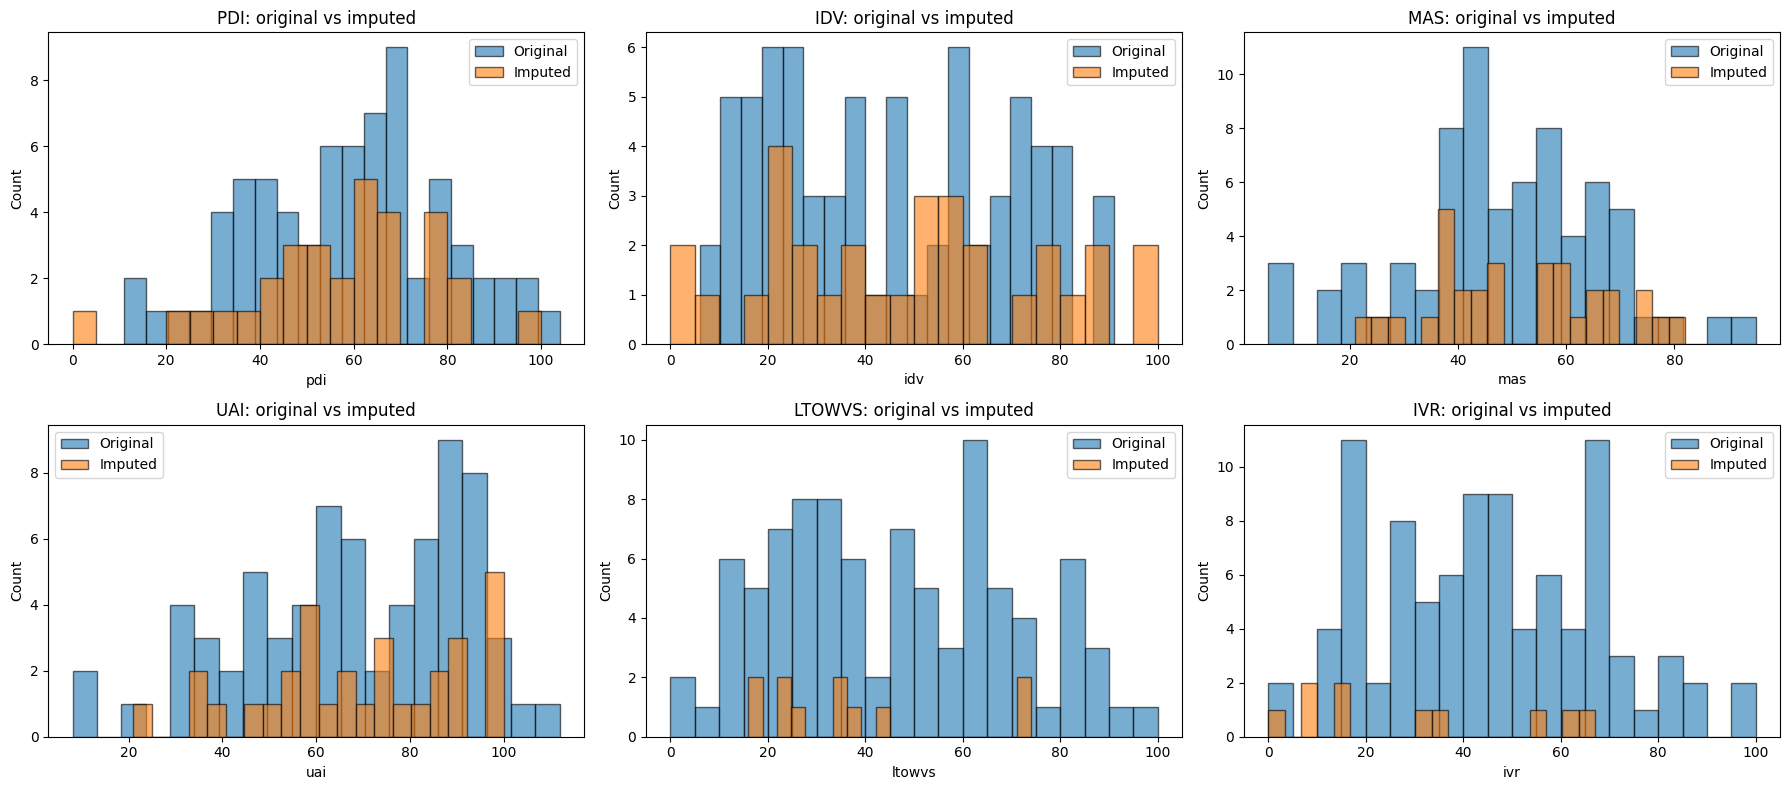

In [ ]:
# Hofstede imputation via PMM-MICE + booking-level region-median fallback

# country-level hofstede frame
hof_cols = ['pdi','idv','mas','uai','ltowvs','ivr']
hof_df = hof.copy()
hof_df['missing_orig'] = hof_df[hof_cols].isna().any(axis=1).astype(int)

# Country-level missing before
cy_missing_orig = int(hof_df['missing_orig'].sum())

# Booking-level missing before
bk_missing_orig = int(bk_full[hof_cols].isna().any(axis=1).sum())

# PMM-MICE setup
imp = IterativeImputer(
    estimator=BayesianRidge(),
    missing_values=np.nan,
    sample_posterior=True,
    max_iter=20,
    initial_strategy='median',
    imputation_order='ascending',
    random_state=0
)

# Fit & transform country-level
imp_arr = imp.fit_transform(hof_df[hof_cols])
imp_df = pd.DataFrame(imp_arr, columns=hof_cols, index=hof_df.index)

# Round & clip to [0,100]
imp_df = imp_df.round().clip(0,100).astype(int)

# Build hof_out with PMM flag
hof_out = hof_df[['country','missing_orig']].join(imp_df)
hof_out['imputed_flag'] = (
    (hof_out['missing_orig']==1) &
    hof_df[hof_cols].isna().any(axis=1)
).astype(int)

# Country-level missing after PMM-MICE
cy_missing_after = int(hof_out[hof_cols].isna().any(axis=1).sum())

# Merge PMM-MICE back into ext & bookings
ext = (
    ext
    .drop(columns=hof_cols, errors='ignore')
    .merge(hof_out[['country'] + hof_cols + ['imputed_flag']],
           on='country', how='left')
)
bk_full = (
    bk_full
    .drop(columns=hof_cols, errors='ignore')
    .merge(hof_out[['country'] + hof_cols + ['imputed_flag']],
           on='country', how='left')
)

# Booking-level missing after PMM-MICE
bk_missing_after_pmm = int(bk_full[hof_cols].isna().any(axis=1).sum())


# Booking-level region-median fallback

# country → region
unsd = pd.read_csv(
    "UNSD.csv", sep=";",
    usecols=["ISO-alpha3 Code","Region Name"]
).rename(columns={
    "ISO-alpha3 Code":"country",
    "Region Name":     "region"
})
bk_full = bk_full.merge(unsd, on="country", how="left")

# recompute region medians from hof_out
hof_reg = hof_out[['country'] + hof_cols].merge(unsd, on="country", how="left")
region_meds = hof_reg.groupby('region')[hof_cols].median()

missing_after_pmm = bk_full[hof_cols].isna()

# fill each Hofstede dim only where it’s still missing and region is known
for col in hof_cols:
    mask = missing_after_pmm[col] & bk_full['region'].notna()
    bk_full.loc[mask, col] = bk_full.loc[mask, 'region'].map(region_meds[col])

# flag the bookings that went from missing-after-PMM to fully non-missing
was_missing = missing_after_pmm.any(axis=1)
now_complete = ~bk_full[hof_cols].isna().any(axis=1)
bk_full['imputed_flag_region'] = (was_missing & now_complete).astype('uint8')

# ensure PMM flag is binary
bk_full['imputed_flag'] = bk_full['imputed_flag'].fillna(0).astype('uint8')

# recompute the still missing ones after region fallback
bk_missing_after_region = int(bk_full[hof_cols].isna().any(axis=1).sum())

# Imputation summary
summary_hof = pd.DataFrame({
    'step': ['orig','after PMM-MICE','after region median'],
    'cy_missing': [cy_missing_orig,  cy_missing_after,  cy_missing_after],
    'bk_missing': [bk_missing_orig, bk_missing_after_pmm, bk_missing_after_region]
})
summary_hof['cy_filled'] = (
    summary_hof['cy_missing'].shift(1, fill_value=cy_missing_orig)
    - summary_hof['cy_missing']
)
summary_hof['bk_filled'] = (
    summary_hof['bk_missing'].shift(1, fill_value=bk_missing_orig)
    - summary_hof['bk_missing']
)

print("\n--- Hofstede imputation summary ---")
display(summary_hof)

# Spot-check known countries
print("\nSanity check: original vs imputed (ITA, BRA, JPN):")
for code in ['ITA','BRA','JPN']:
    orig = hof_df.loc[hof_df['country']==code, hof_cols].iloc[0].to_dict()
    impt = imp_df.loc[hof_df['country']==code, hof_cols].iloc[0].to_dict()
    print(f"\n{code}:")
    print("original:", orig)
    print("imputed :", impt)

# Histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()
for ax, col in zip(axes, hof_cols):
    orig_vals = hof_df[col].dropna()
    imp_vals  = imp_df.loc[hof_df[col].isna(), col]
    ax.hist(orig_vals, bins=20, alpha=0.6, label='Original', edgecolor='black')
    ax.hist(imp_vals, bins=20, alpha=0.6, label='Imputed',  edgecolor='black')
    ax.set_title(f"{col.upper()}: original vs imputed")
    ax.set_xlabel(col); ax.set_ylabel("Count"); ax.legend()
for ax in axes[len(hof_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
# Global‐median safety net

# Identify missing countries at country‐level and booking‐level before global fill

# country‐level
missing_countries_country = hof_out.loc[
    hof_out[hof_cols].isna().any(axis=1),
    'country'
].unique().tolist()
print("Countries in hof_out still missing Hofstede dims:", missing_countries_country)

# booking‐level
missing_countries_booking = bk_full.loc[
    bk_full[hof_cols].isna().any(axis=1),
    'country'
].unique().tolist()
print("Countries in bk_full still missing before global fill:", missing_countries_booking)


# Compute global medians from the (PMM+region‐imputed) country table
global_meds = hof_out[hof_cols].median()
print("\nGlobal medians for final fill:")
print(global_meds.to_dict())

# Country‐level final fill
hof_out[hof_cols] = hof_out[hof_cols].fillna(global_meds)

# Booking‐level final fill mask
mask_global = bk_full[hof_cols].isna().any(axis=1)

# Apply global‐median fill to bookings
for col in hof_cols:
    bk_full.loc[mask_global, col] = global_meds[col]

# Build unified booking‐level flag
bk_full['booking_hofstede_imputed'] = (
       bk_full['imputed_flag'].eq(1)         # filled by PMM‐MICE
    |  bk_full['imputed_flag_region'].eq(1)  # filled by region median
    |  mask_global                           # filled by global median
).astype('uint8')

# Verification of region & global fills

# Recompute region medians from hof_out BEFORE global fill
hof_reg = hof_out[['country'] + hof_cols].merge(unsd, on='country', how='left')
region_meds = hof_reg.groupby('region')[hof_cols].median()

# Booking-level region fill check
bk_region = (
    bk_full[bk_full['imputed_flag_region']==1]
    [['country','region'] + hof_cols]
    .drop_duplicates()
    .reset_index(drop=True)
)
chk = bk_region.merge(
    region_meds.reset_index(), on='region', suffixes=('','_med')
)
region_errors = []
for col in hof_cols:
    bad = chk[chk[col] != chk[f"{col}_med"]]
    if len(bad):
        region_errors.append((col, len(bad)))
if not region_errors:
    print("Booking-level region fill: correct on all flagged rows")
else:
    print("Booking-level region fill mismatches:", region_errors)

# Booking-level global fill check
global_errors = []
for col in hof_cols:
    bad = bk_full.loc[mask_global, col] != global_meds[col]
    if bad.any():
        global_errors.append((col, bad.sum()))
if not global_errors:
    print("Booking-level global fill: correct on all remaining NAs")
else:
    print("Booking-level global fill mismatches:", global_errors)

# Flag consistency check
# ensure booking_hofstede_imputed equals union of the 3
flag_union = (
      bk_full['imputed_flag'].eq(1)
    | bk_full['imputed_flag_region'].eq(1)
    | mask_global
)
if (bk_full['booking_hofstede_imputed'] == flag_union).all():
    print("Unified booking_hofstede_imputed flag is consistent")
else:
    print("booking_hofstede_imputed doesn’t match the union of sub-flags")

# Drop the intermediate flags & region column
bk_full.drop(columns=['region','imputed_flag','imputed_flag_region'],
             errors='ignore', inplace=True)

# Verify no Hofstede dims remain missing
print("\nRemaining missing counts:")
print(bk_full[hof_cols].isna().sum())

print(bk_full['booking_hofstede_imputed'].value_counts(dropna=False))

cols_to_show = ['country', 'arrival_year'] + hof_cols + ['booking_hofstede_imputed']

# Preview
display(
    bk_full[cols_to_show]
    .head(10)
)


Countries in hof_out still missing Hofstede dims: []
Countries in bk_full still missing before global fill: ['UNK', 'ATA']

Global medians for final fill:
{'pdi': 60.0, 'idv': 45.5, 'mas': 47.0, 'uai': 70.0, 'ltowvs': 39.5, 'ivr': 43.0}
Booking-level region fill: correct on all flagged rows
Booking-level global fill: correct on all remaining NAs
Unified booking_hofstede_imputed flag is consistent

Remaining missing counts:
pdi       0
idv       0
mas       0
uai       0
ltowvs    0
ivr       0
dtype: int64
booking_hofstede_imputed
0    116609
1      2781
Name: count, dtype: int64


,country,arrival_year,pdi,idv,mas,uai,ltowvs,ivr,booking_hofstede_imputed
0,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0
1,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0
2,GBR,2015,35.0,89.0,66.0,35.0,51.0,69.0,0
3,GBR,2015,35.0,89.0,66.0,35.0,51.0,69.0,0
4,GBR,2015,35.0,89.0,66.0,35.0,51.0,69.0,0
5,GBR,2015,35.0,89.0,66.0,35.0,51.0,69.0,0
6,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0
7,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0
8,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0
9,PRT,2015,63.0,27.0,31.0,100.0,28.0,33.0,0


**Comprehensive Checkup & Outlier Detection**

In [ ]:
# Comprehensive checkup of bk_full & outlier detection

df = bk_full.copy()

# Shape & memory usage
rows, cols = df.shape
mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Dataset shape: {rows:,} rows × {cols:,} columns")
print(f"Total memory usage: {mem_mb:.2f} MB\n")

# DataFrame schema & non-null counts
print("DataFrame info:")
df.info(verbose=True, show_counts=True)
print()

# Column-level overview: dtype, missing, % missing, unique
col_stats = pd.DataFrame({
    'dtype':       df.dtypes,
    'missing':     df.isna().sum(),
    'pct_missing': (df.isna().mean() * 100).map('{:.1f}%'.format),
    'unique':      df.nunique()
})

print("Column overview:")
print(col_stats)

# Numeric features: descriptive statistics
num_df = df.select_dtypes(include=[np.number])
print("Numeric features summary:")
print(tabulate(
    num_df.describe().T.reset_index().values,
    headers=['feature','count','mean','std','min','25%','50%','75%','max'],
    tablefmt='psql'
))
print()


Dataset shape: 119,390 rows × 71 columns
Total memory usage: 31.22 MB

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 71 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  category      
 1   is_canceled                     119390 non-null  int8          
 2   lead_time                       119390 non-null  int16         
 3   adults                          119390 non-null  int8          
 4   children                        119390 non-null  uint8         
 5   babies                          119390 non-null  int8          
 6   meal                            119390 non-null  category      
 7   country                         119390 non-null  object        
 8   market_segment                  119390 non-null  category      
 9   distribution_channel            119390

In [ ]:
# Identify all numeric cols
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# summary container
summary = []

# Loop through each numeric feature and count outliers
for col in num_cols:
    s = df[col].dropna()

    # IQR outliers
    Q1, Q3 = s.quantile([0.25, 0.75])
    IQR   = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_count = int(((df[col] < lower) | (df[col] > upper)).sum())

    # Z-score outliers
    if s.nunique() > 1:
        z = (df[col] - s.mean()) / s.std(ddof=0)
        z_count = int((z.abs() > 3).sum())
    else:
        z_count = 0

    # Negative-value count
    if s.min() < 0:
        neg_count = int((df[col] < 0).sum())
    else:
        neg_count = 0

    # Append to summary
    summary.append({
        'feature':   col,
        'iqr_count': iqr_count,
        'z_count':   z_count,
        'neg_count': neg_count
    })

# Summary
summary_df = (
    pd.DataFrame(summary)
      .sort_values(['neg_count', 'iqr_count'], ascending=False)
      .reset_index(drop=True)
)
print(summary_df[['feature','iqr_count','z_count','neg_count']])


                           feature  iqr_count  z_count  neg_count
0                       cancel_lag      18635     3496      74460
1                    inflation_pct       5868      668      11401
2              real_gdp_growth_pct      15852     1035       7458
3                   gdp_growth_pct       7431     1987       1946
4                              adr       3793     1138          1
5                     total_guests      37339      154          0
6                           adults      29710      481          0
7              booking_wdi_imputed      26132        0          0
8             tourism_receipts_usd      23310     2097          0
9                    pop_15_64_pct      18931     2314          0
10                 booking_changes      18076     1570          0
11              flag_deposit_taken      14749        0          0
12                 pop_65_plus_pct      10896     2858          0
13              mobile_subs_per100       9954     1616          0
14        

In [ ]:
# Domain‐specific corrections
print("--- Domain corrections")
print(f"Negative ADR before: {(df['adr'] < 0).sum()}; negative cancel_lag before: {(df['cancel_lag'] < 0).sum()}")
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()
df.loc[df['cancel_lag'] < 0, 'cancel_lag'] = 0
print(f"Negative ADR after: {(df['adr'] < 0).sum()}; negative cancel_lag after: {(df['cancel_lag'] < 0).sum()}\n")

# Identify numeric columns (exclude truly categorical codes)
num_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in ('arrival_year',) # treat arrival_year as categorical
]

# Continuous features for IQR‐winsorization
cont_vars = []
for col in num_cols:
    s = df[col].dropna()
    Q1, Q3 = s.quantile([0.25, 0.75])
    if col in ('adr', 'cancel_lag') or (s.nunique() > 100 and Q3 > Q1):
        cont_vars.append(col)
print("Continuous features to winsorize (IQR):", cont_vars, "\n")

# Capture pre‐IQR stats
pre_iqr = {}
for col in cont_vars:
    s = df[col]
    Q1, Q3 = s.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    pre_iqr[col] = {
        'orig_min': s.min(),
        'orig_max': s.max(),
        'lower_fence': Q1 - 1.5 * IQR,
        'upper_fence': Q3 + 1.5 * IQR,
        'skew': s.skew()
    }

# Apply one‐sided or two‐sided IQR clipping based on skew
print("--- Applying refined IQR clipping based on skew")
for col, stats in pre_iqr.items():
    s = df[col]
    lf, uf = stats['lower_fence'], stats['upper_fence']
    skew = stats['skew']
    if skew > 0.5:
        # right‐skewed: only cap the upper tail
        df[col] = s.clip(upper=uf)
    elif skew < -0.5:
        # left‐skewed: only cap the lower tail
        df[col] = s.clip(lower=lf)
    else:
        # roughly symmetric: cap both tails
        df[col] = s.clip(lower=lf, upper=uf)

# Verify refined IQR winsorization
print("--- Refined IQR winsorization verification:")
for col, stats in pre_iqr.items():
    new_min, new_max = df[col].min(), df[col].max()
    print(f"{col:25s} | skew {stats['skew']:+5.3f} | "
          f"orig_min {stats['orig_min']:<8.3f}→ new_min {new_min:<8.3f} | "
          f"orig_max {stats['orig_max']:<8.3f}→ new_max {new_max:<8.3f}")
print()

# Low‐cardinality counts for 99th‐percentile capping (3 <= nunique <= 100), excluded 'babies'
low_card = [
    c for c in num_cols
    if c not in cont_vars and df[c].nunique() > 2 and df[c].nunique() <= 100
    and c != 'babies'
]
print("Low‐cardinality features to percentile‐cap:", low_card, "\n")

# pre‐percentile stats
pre_pct = {c: {'orig_max': df[c].max(), 'p99': df[c].quantile(0.99)} for c in low_card}

# Apply 99th‐percentile cap
for c, stats in pre_pct.items():
    df[c] = df[c].clip(upper=stats['p99'])

# Verify percentile capping
print("--- 99th‐percentile capping verification:")
for c, stats in pre_pct.items():
    print(f"{c:25s} | orig_max {stats['orig_max']:<8.3f}→ new_max {df[c].max():<8.3f} (p99 {stats['p99']:<8.3f})")
print()

# Cap for babies
orig_babies_max = df['babies'].max()
df['babies'] = df['babies'].clip(upper=1)
print(f"Babies: orig_max {orig_babies_max} → capped_max {df['babies'].max()}\n")

# Skewness check on continuous features
skews = df[cont_vars].skew().round(3)
print("--- Skewness before log1p:")
print(skews.to_frame('skew_before'), "\n")

# log1p positively skewed vars (skew > 1)
to_log = skews[skews > 1].index.tolist()
print("Applying log1p to:", to_log, "\n")

pre_log = {c: {'mean': df[c].mean(), 'std': df[c].std()} for c in to_log}
for c in to_log:
    df[c] = np.log1p(df[c])

# Verify skewness after log1p
print("--- Skewness after log1p:")
post_skews = {}
for c in to_log:
    post_skews[c] = df[c].skew().round(3)
    print(f"{c:25s} | skew_before {skews[c]:>6.3f}→ skew_after {post_skews[c]:>6.3f} "
          f"(mean {pre_log[c]['mean']:.3f}→{df[c].mean():.3f})")

# Cube‐root transform for any still skewed >1
still_heavy = [c for c, sk in post_skews.items() if sk > 1]
print("\nStill skewed >1 after log1p:", still_heavy)
for c in still_heavy:
    df[c] = np.cbrt(df[c])

# Verify final skewness
print("\n--- Final skewness after cube‐root:")
for c in still_heavy:
    print(f"{c:25s} | skew_after_cuberoot {df[c].skew().round(3):>6.3f}")


--- Domain corrections
Negative ADR before: 1; negative cancel_lag before: 74460
Negative ADR after: 0; negative cancel_lag after: 0

Continuous features to winsorize (IQR): ['lead_time', 'adr', 'cancel_lag', 'bookings_count', 'cancellation_rate', 'population_density', 'inflation_pct', 'mobile_subs_per100', 'internet_users_pct', 'gdp_growth_pct', 'gdp_per_capita_usd', 'unemployment_pct', 'pop_15_64_pct', 'pop_65_plus_pct', 'population_total', 'urban_pop_pct', 'tourism_departures', 'tourism_receipts_usd', 'tourism_departures_per_1000', 'tourism_receipts_per_capita', 'tourism_share_of_gdp', 'real_gdp_growth_pct', 'digital_penetration_index', 'pop_0_14_pct', 'dependency_ratio'] 

--- Applying refined IQR clipping based on skew
--- Refined IQR winsorization verification:
lead_time                 | skew +1.347 | orig_min 0.000   → new_min 0.000    | orig_max 737.000 → new_max 373.000 
adr                       | skew +10.531 | orig_min 0.000   → new_min 0.000    | orig_max 5400.000→ new_ma

In [ ]:
sample_df = df.sample(10)
print("--- Sample check ---")
print(tabulate(sample_df, headers='keys', tablefmt='psql', showindex=False))

# Re-select numeric columns (drop any unwanted flags)
num_df = df.select_dtypes(include=[np.number]).drop(
    columns=['flag_negative_adr'],  # already handled
    errors='ignore'
)

# Correlation matrix
corr = num_df.corr()

# Print the full correlation matrix
corr_reset = corr.reset_index()
print("\n--- Correlation matrix (numeric only) ---")
print(tabulate(corr_reset, headers=corr_reset.columns, tablefmt='psql', showindex=False))

# Identify all pairs with |corr| > 0.8
threshold = 0.8
pairs = []
cols = corr.columns.tolist()
for i, feat1 in enumerate(cols):
    for feat2 in cols[i+1:]:
        val = corr.at[feat1, feat2]
        if abs(val) > threshold:
            pairs.append({'feature_1': feat1, 'feature_2': feat2, 'corr_value': val})

high_corr_df = pd.DataFrame(pairs).sort_values(
    by='corr_value',
    key=lambda x: x.abs(),
    ascending=False
).reset_index(drop=True)

# Highly correlated pairs
print(f"\n--- Highly correlated feature pairs (|corr| > {threshold}) ---")
if high_corr_df.empty:
    print("None found.")
else:
    print(tabulate(high_corr_df, headers='keys', tablefmt='psql', showindex=False))


--- Sample check ---
+--------------+---------------+-------------+----------+------------+----------+--------+-----------+------------------+------------------------+---------------------+--------------------------+----------------------------------+----------------------+----------------------+-------------------+----------------+---------+------------------------+-----------------+--------+-------------------------------+-----------------------------+----------------------+---------------------------+---------------------+----------------+----------------+----------------+--------------+-----------------+----------+----------------+-----------------------+-------------------------+----------------------+------------------------+--------------------------+---------------------------+---------------------+--------------------+------------------+---------------------+----------------------+-----------------+----------------------+----------------------+------------------+--------------

In [ ]:
# Drop the perfectly or highly redundant columns and unwanted flags
to_drop = [
    'flag_repeated_guest',         # duplicate of is_repeated_guest
    'pop_0_14_pct',                # redundant with dependency_ratio
    'flag_negative_adr',           # negative adr outlier is treated
    'cancel_lag',                  # highly correlated with the target
    'flag_cancel_lag_outlier'
]
df = df.drop(columns=to_drop, errors='ignore')

print("Dropped:", to_drop)

Dropped: ['flag_repeated_guest', 'pop_0_14_pct', 'flag_negative_adr', 'cancel_lag', 'flag_cancel_lag_outlier']


In [ ]:
# Copy cleaned DataFrame back to bk_full
bk_full = df.copy()

# Export to CSV
output_path = 'bk_full_cleaned.csv'
bk_full.to_csv(output_path, index=False)
print(f"Saved cleaned DataFrame to {output_path}")

from google.colab import files
files.download(output_path)

Saved cleaned DataFrame to bk_full_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>